In [1]:
import sys
import gc
import os
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scvi
import plotnine as p9 
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import anndata
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

In [4]:
tissues = [
         'Blood',
         'Fat',
         'Heart',
         
         #'Large_Intestine',
         
         #'Lung',
         
         'Muscle',



         'Salivary_Gland',
         'Skin',
         #'Small_Intestine',
         'Spleen',
         'Vasculature'
       ]

folder_path = '/hpc/projects/tabula_sapiens/singlecell_transcriptomics/TSP1_30_Paper2_Version2d_Oct2024/tissues/Skin_TSP1_30_version2d_10X_smartseq_scvi_Dec42024_updated.h5ad'
file_path_list = [os.path.join(folder_path,i+'_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad') for i in tissues]
def get_tissue_data(tissue_name):
    ## filter out smartseq data
    adata = sc.read_h5ad(file_path_list[tissues.index(tissue_name)])
    adata = adata[adata.obs['method']!='smartseq'].copy()
    return adata

In [5]:
TS_tissue_adata_all = []
for tissue_ in tissues:
    print('load TS data for organ : '+tissue_)
    TS_tissue_adata = get_tissue_data(tissue_)
    TS_tissue_adata_all.append(TS_tissue_adata)

load TS data for organ : Blood
load TS data for organ : Fat
load TS data for organ : Heart
load TS data for organ : Muscle
load TS data for organ : Salivary_Gland
load TS data for organ : Skin


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/hpc/projects/tabula_sapiens/singlecell_transcriptomics/TSP1_30_Paper2_Version2d_Oct2024/tissues/Skin_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
TS_tissue_adata_all = anndata.concat(TS_tissue_adata_all)

In [7]:
sc.pp.filter_genes(TS_tissue_adata_all,min_cells=50)

In [8]:
TS_tissue_adata_all

AnnData object with n_obs × n_vars = 281491 × 39680
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'n_cells'
    obsm: 'X_pca', 'X_scvi', 'X_tissue_uncorrected_umap', 'X_umap', 'X_umap_scvi_full_donorassay', 'X_umap_tissue_scvi_donorassay', 'X_uncorrected_umap'
    layers: 'decontXcounts', 'log_normalized', 'raw_counts', 'scale_data'

# load GTEx data with paired tissue

In [9]:
def load_GTEx():
    tissue_map_GTEx = {
                    'Adipose_Subcutaneous':'ADPSBQ', 
                    'Adipose_Visceral_Omentum':'ADPVSC',
                    'Adrenal_Gland':'ADRNLG', 
                    'Artery_Aorta':'ARTAORT', 
                    'Artery_Coronary':'ARTCRN',
                    'Artery_Tibial':'ARTTBL', 
                    'Brain_Amygdala':'BRNAMY',
                    'Brain_Anterior_cingulate_cortex_BA24':'BRNACC',
                    'Brain_Caudate_basal_ganglia':'BRNCDT', 
                    'Brain_Cerebellar_Hemisphere':'BRNCHB',
                    'Brain_Cerebellum':'BRNCHA', 
                    'Brain_Cortex':'BRNCTXA', 
                    'Brain_Frontal_Cortex_BA9':'BRNCTXB',
                    'Brain_Hippocampus':'BRNHPP', 
                    'Brain_Hypothalamus':'CRNHPT',
                    'Brain_Nucleus_accumbens_basal_ganglia':'BRNNCC',
                    'Brain_Putamen_basal_ganglia':'BRNPTM', 
                    'Brain_Spinal_cord_cervical_c.1':'BRNSPC',
                    'Brain_Substantia_nigra':'BRNSNG', 
                    'Breast_Mammary_Tissue':'BREAST',
                    'Cells_Cultured_fibroblasts':'FIBRBLS', 
                    'Cells_EBV.transformed_lymphocytes':'LCL',
                    'Colon_Sigmoid':'CLNSGM', 
                    'Colon_Transverse':'CLNTRN',
                    'Esophagus_Gastroesophageal_Junction':'ESPGEJ', 
                    'Esophagus_Mucosa':'ESPMCS',
                    'Esophagus_Muscularis':'ESPMSL', 
                    'Heart_Atrial_Appendage':'HRTAA',
                    'Heart_Left_Ventricle':'HRTLV', 
                    'Kidney_Cortex':'KDNCTX', 
                    'Liver':'LIVER', 
                    'Lung':'LUNG',
                    'Minor_Salivary_Gland':'SLVRYG',
                    'Muscle_Skeletal':'MSCLSK', 
                    'Nerve_Tibial':'NERVET',
                    'Pancreas':'PNCREAS', 
                    'Pituitary':'PTTARY', 
                    'Skin_Not_Sun_Exposed_Suprapubic':'SKINNS',
                    'Skin_Sun_Exposed_Lower_leg':'SKINS', 
                    'Small_Intestine_Terminal_Ileum':'SNTTRM',
                    'Spleen':'SPLEEN', 
                    'Stomach':'STMACH', 
                    'Thyroid':'THYROID', 
                    'Whole_Blood':'WHLBLD'

                }

    gtex_de = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/GTEx_Analysis_v8_sbgenes/signif.sbgenes.txt', sep='\t')

    # Load GTF data
    gtf = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/gencode.v41.annotation.gtf', comment='#', sep='\t', header=None)
    gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
    gtf.columns = gtf_columns
    gtf['gene_id'] = gtf['attribute'].str.extract('gene_id "([^"]+)"')
    gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')
    gtf['gene_type'] = gtf['attribute'].str.extract('gene_type "([^"]+)"')
    gtf['chr'] = gtf['seqname']

    # Create mappings
    gene_symbol_mapping = gtf[['gene_id', 'gene_name']].drop_duplicates()
    gene_chr_mapping = gtf[['gene_id', 'chr']].drop_duplicates()
    gene_type_mapping = gtf[['gene_id', 'gene_type']].drop_duplicates()

    id_to_symbol = {row['gene_id'].split('.')[0]: row['gene_name'] for index, row in gene_symbol_mapping.iterrows()}
    id_to_chr = {row['gene_id'].split('.')[0]: row['chr'] for index, row in gene_chr_mapping.iterrows()}
    id_to_type = {row['gene_id'].split('.')[0]: row['gene_type'] for index, row in gene_type_mapping.iterrows()}

    # Map gene IDs to symbols and chromosome numbers
    gtex_de['gene_symbol'] = gtex_de['gene'].map(lambda x: id_to_symbol.get(x.split('.')[0], x))
    gtex_de['chr'] = gtex_de['gene'].map(lambda x: id_to_chr.get(x.split('.')[0]))
    # Add coding_status
    gtex_de['coding_status'] = gtex_de['gene'].map(lambda x: 'coding' if id_to_type.get(x.split('.')[0]) == 'protein_coding' else 'non-coding')

    gtex_de['tissue_rename'] = gtex_de['tissue'].map(lambda x: tissue_map_GTEx.get(x, x))
    gtex_de.index = gtex_de['gene_symbol'].values

    mapping_dict = {'Fat':['ADPSBQ','ADPVSC'],
            'Spleen':['SPLEEN'],
            'Salivary_Gland':['SLVRYG'],
            'Lung':['LUNG'],
            'Blood':['WHLBLD'],
            'Skin':['SKINNS','SKINS'],
            'Small_Intestine':['SNTTRM'],
            'Muscle':['MSCLSK'],
            'Vasculature':['ARTTBL','ARTAORT','ARTCRN'],
            'Heart':['HRTAA','HRTLV'],
            'Large_Intestine':['CLNSGM','CLNTRN']
    }
    items_list = [item for sublist in mapping_dict.values() for item in sublist]

    gtex_de = gtex_de[gtex_de['tissue_rename'].isin(items_list)] 
    
    # Load effect size data
    effect_size_all = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/GTEx_Analysis_v8_sbgenes/effect_size.tsv', sep='\t')
    effect_size_all.index = effect_size_all.index.map(lambda x: x.split('.')[0])
    effect_size_all['gene_symbol'] = effect_size_all.index.map(lambda x: id_to_symbol.get(x, x))
    effect_size_all['chr'] = effect_size_all.index.map(lambda x: id_to_chr.get(x))
    # Add coding_status
    effect_size_all['coding_status'] = effect_size_all.index.map(lambda x: 'coding' if id_to_type.get(x) == 'protein_coding' else 'non-coding')
    effect_size_all.index = effect_size_all['gene_symbol'].values

    return gtex_de,effect_size_all

In [10]:
GTEx_data_df, GTEx_data_raw = load_GTEx()

In [11]:
from venn import venn
def plot_venn(TS_gene, GTEx_gene):
    
    DEG_list_venn = {}
    DEG_list_venn['TS'] =  TS_gene
    DEG_list_venn['GTEx'] = GTEx_gene

    fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=800)
    venn(DEG_list_venn, 
             fontsize=12, 
             legend_loc="right", 
             ax=ax)
    # Get the Axes object from the Venn diagram
    ax = plt.gca()
    # Adjust the legend position using loc parameter
    ax.legend(DEG_list_venn.keys(),bbox_to_anchor=(1.2, 0.8))
    plt.tight_layout()
    plt.show()

In [13]:
overlap_gene_list = list(set(TS_tissue_adata_all.var_names)&set(GTEx_data_raw.index))


In [18]:
with open("overlap_gene_list.txt", "w") as f:
    for gene in overlap_gene_list:
        f.write(f"{gene}\n")

In [30]:
x_genes = list(set(GTEx_data_df[GTEx_data_df['chr']=='chrX'].index.unique())|set(TS_data_df[TS_data_df['chr']=='chrX'].index.unique()))

with open("xlinkedgenes.txt", "w") as f:
    for gene in x_genes:
        f.write(f"{gene}\n")

In [17]:
overlap_gene_list

['RBPMS',
 'FA2H',
 'HCG25',
 'ENSG00000236332',
 'GABRG2',
 'ENSG00000278974',
 'ENSG00000228919',
 'TIGIT',
 'KCTD16',
 'ENSG00000225213',
 'ENSG00000269694',
 'ASXL1',
 'DEF8',
 'F3',
 'TPP1',
 'HERPUD1',
 'ENSG00000274554',
 'HNRNPA1P16',
 'ENSG00000265630',
 'TMEM255A',
 'ENSG00000272971',
 'ENSG00000259515',
 'ENSG00000269986',
 'LRPAP1',
 'ENSG00000228877',
 'RFX3-DT',
 'CAST',
 'ZBED6',
 'ENSG00000283692',
 'DUS1L',
 'PRR27',
 'MTRFR',
 'KCNAB3',
 'ADH5',
 'TRAV30',
 'VPS16',
 'PAQR3',
 'LINC00659',
 'MSRB3',
 'RPS7P11',
 'PTMA',
 'TICAM2-AS1',
 'NPAS2',
 'ASB12',
 'FAHD2B',
 'KRTAP5-AS1',
 'ZNF366',
 'FRMD6',
 'PLA2G4A',
 'ENSG00000187186',
 'ZNF510',
 'AHCYL2',
 'ENSG00000272130',
 'PCDH11X',
 'AKR7A3',
 'CUEDC1',
 'ENSG00000256417',
 'ENSG00000259782',
 'ENSG00000254002',
 'ENSG00000231043',
 'ENSG00000238142',
 'HPF1',
 'CFHR1',
 'ENSG00000258084',
 'YWHAG',
 'FAM183A',
 'IGBP1-AS1',
 'NFATC4',
 'ENSG00000262833',
 'LINC02360',
 'ENSG00000276945',
 'LINC02178',
 'TRBC2',
 '

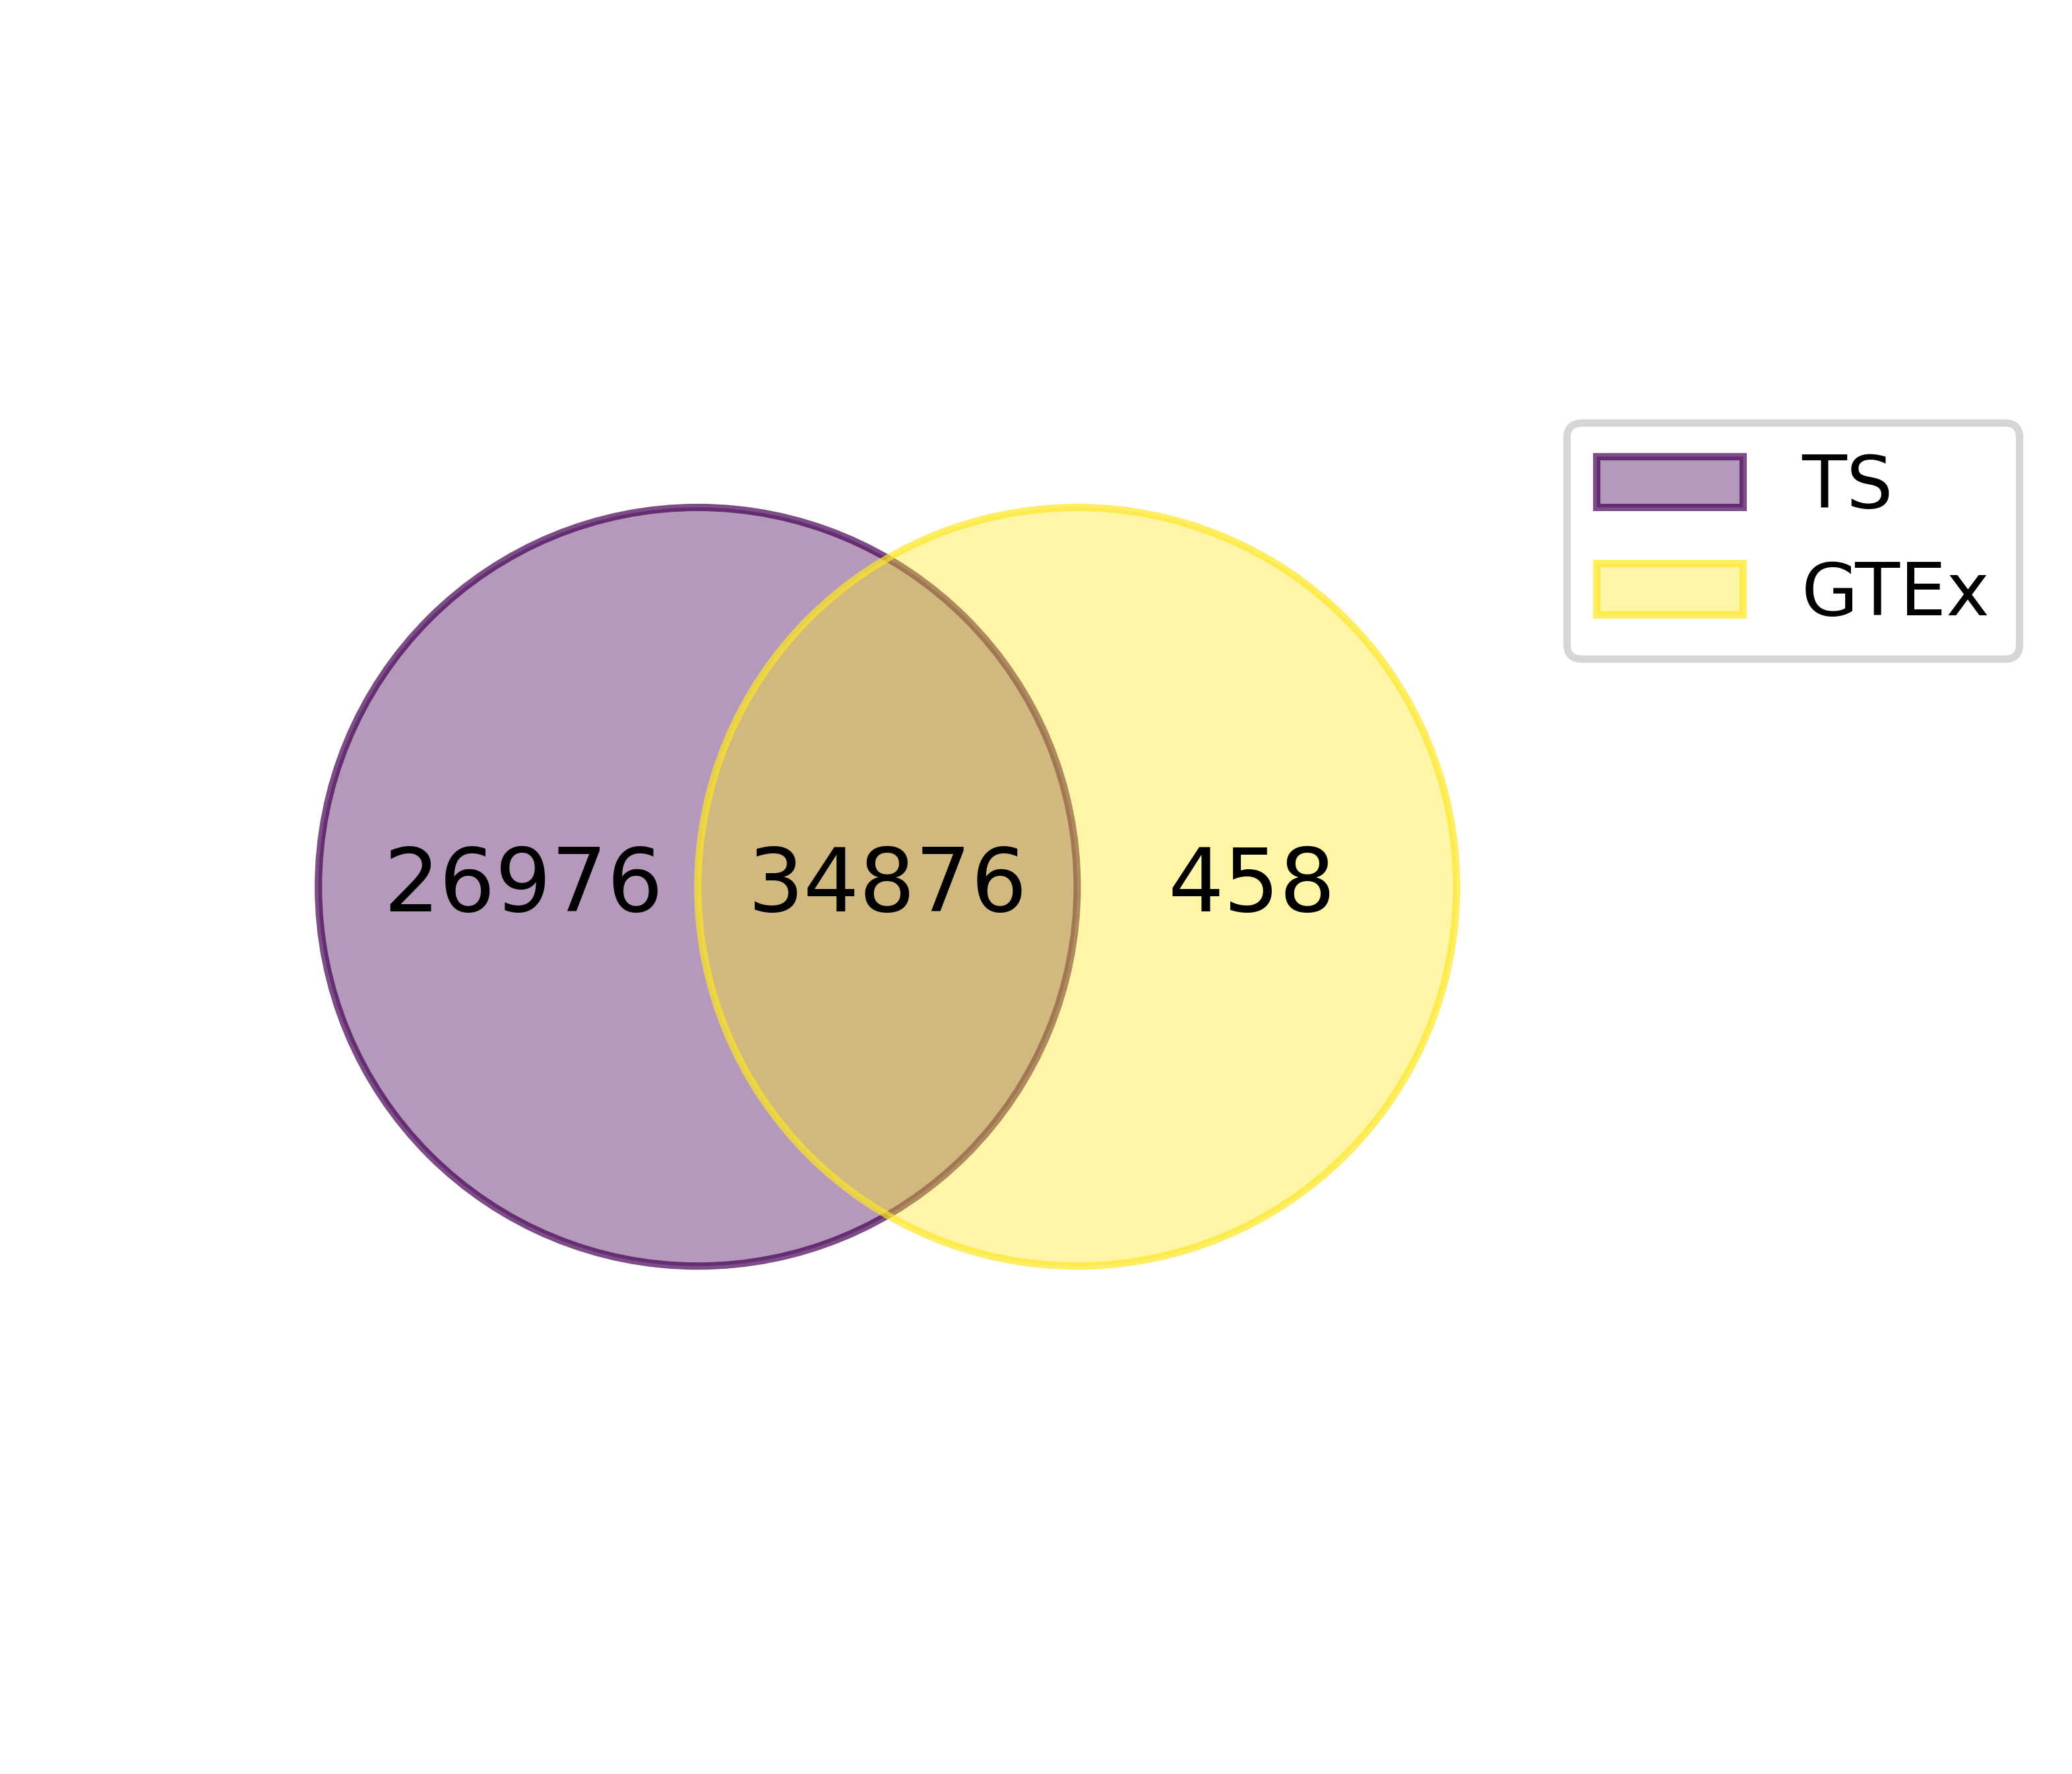

In [16]:
plot_venn(TS_gene = set(TS_tissue_adata_all.var_names),
             GTEx_gene = set(GTEx_data_raw.index))

In [17]:
len(set(TS_tissue_adata_all.var_names))

61852

In [18]:
365/(365+74)

0.8314350797266514

In [19]:
union_genes = set(TS_tissue_adata_all.var_names) & set(GTEx_data_raw.index)

In [20]:
len(union_genes)

34876

# load TS data with paired tissue

In [25]:
def load_TS():
    DEG_all = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/edgeR_LRT_all_DEGs.csv',index_col=0)
    DEG_all.index = DEG_all['gene_symbol'].values

    gtf = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/gencode.v41.annotation.gtf', comment='#', sep='\t', header=None)
    gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
    gtf.columns = gtf_columns

    # Extract gene name and gene type from the attributes column
    gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')
    gtf['gene_type'] = gtf['attribute'].str.extract('gene_type "([^"]+)"')
    gtf['chr'] = gtf['seqname']

    gene_info_mapping = gtf[['gene_name', 'chr', 'gene_type']].drop_duplicates().set_index('gene_name')

    # Map gene information to DEG data
    DEG_all = DEG_all.join(gene_info_mapping, on='gene_symbol')

    DEG_all['coding_status'] = DEG_all['gene_type'].apply(lambda x: 'coding' if x == 'protein_coding' else 'non-coding')


    return DEG_all

def load_TS_tissue():
    DEG_all = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/edgeR_LRT_all_DEGs_tissue.csv',index_col=0)
    DEG_all.index = DEG_all['gene_symbol'].values

    gtf = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/TS_project/gencode.v41.annotation.gtf', comment='#', sep='\t', header=None)
    gtf_columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
    gtf.columns = gtf_columns
    # Extract gene name and gene type from the attributes column
    gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')
    gtf['gene_type'] = gtf['attribute'].str.extract('gene_type "([^"]+)"')
    gtf['chr'] = gtf['seqname']

    gene_info_mapping = gtf[['gene_name', 'chr', 'gene_type']].drop_duplicates().set_index('gene_name')

    # Map gene information to DEG data
    DEG_all = DEG_all.join(gene_info_mapping, on='gene_symbol')
    DEG_all['coding_status'] = DEG_all['gene_type'].apply(lambda x: 'coding' if x == 'protein_coding' else 'non-coding')

    return DEG_all

In [26]:
TS_data_df = load_TS()
TS_data_tissue_df = load_TS_tissue()

In [27]:
GTEx_data_df = GTEx_data_df.loc[np.intersect1d(GTEx_data_df.index,list(union_genes)),:]
TS_data_df = TS_data_df.loc[np.intersect1d(TS_data_df.index,list(union_genes)),:]
TS_data_tissue_df = TS_data_tissue_df.loc[np.intersect1d(TS_data_tissue_df.index,list(union_genes)),:]

NameError: name 'union_genes' is not defined

In [ ]:
GTEx_data_df['tissue_rename'].unique()

In [29]:
TS_data_df = TS_data_df[TS_data_df['tissue'].isin([
'Fat',
'Spleen',
'Salivary_Gland',
'Lung',
'Blood',
'Skin',
'Small_Intestine',
'Muscle',
'Vasculature',
'Heart',
'Large_Intestine'])]

TS_data_tissue_df = TS_data_tissue_df[TS_data_tissue_df['tissue'].isin([
'Fat',
'Spleen',
'Salivary_Gland',
'Lung',
'Blood',
'Skin',
'Small_Intestine',
'Muscle',
'Vasculature',
'Heart',
'Large_Intestine'])]

In [30]:
GTEx_data_df['tissue_rename'].unique().shape

(17,)

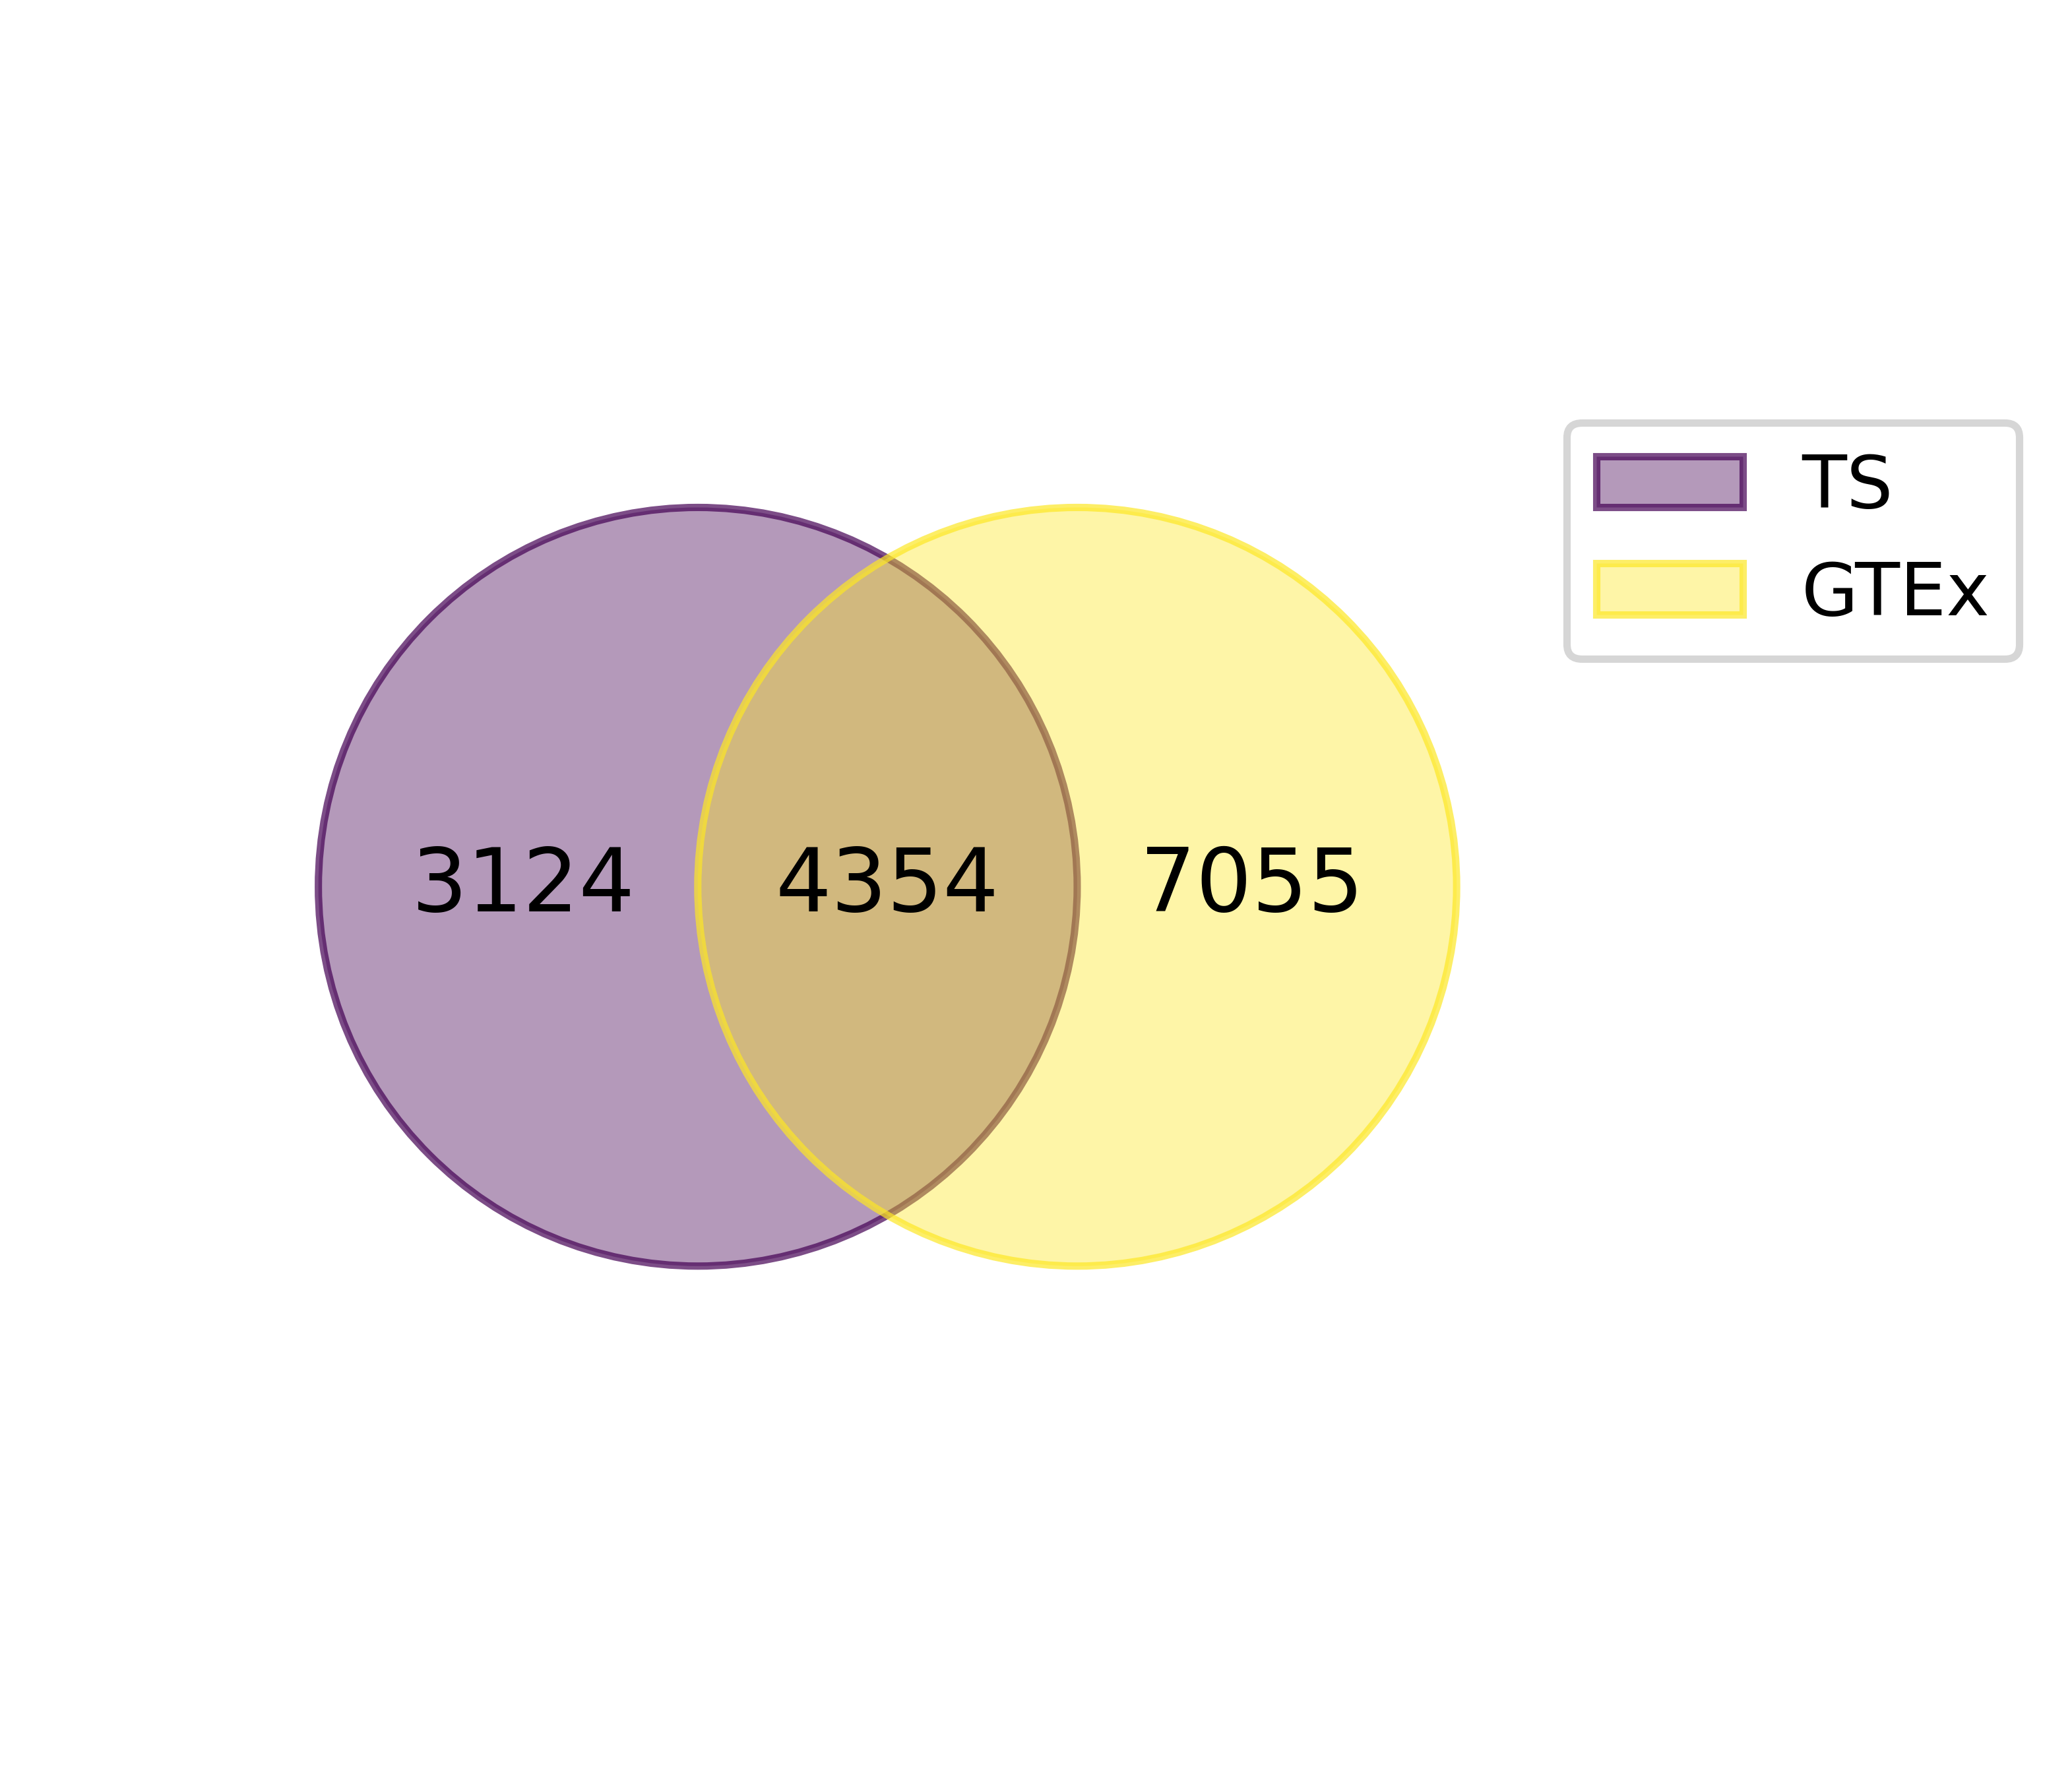

In [31]:
plot_venn(TS_gene = set(np.intersect1d(list(TS_data_df.index.unique()), list(union_genes))),
                       GTEx_gene = set(np.intersect1d(list(GTEx_data_df.index.unique()), list(union_genes))), 
                      )

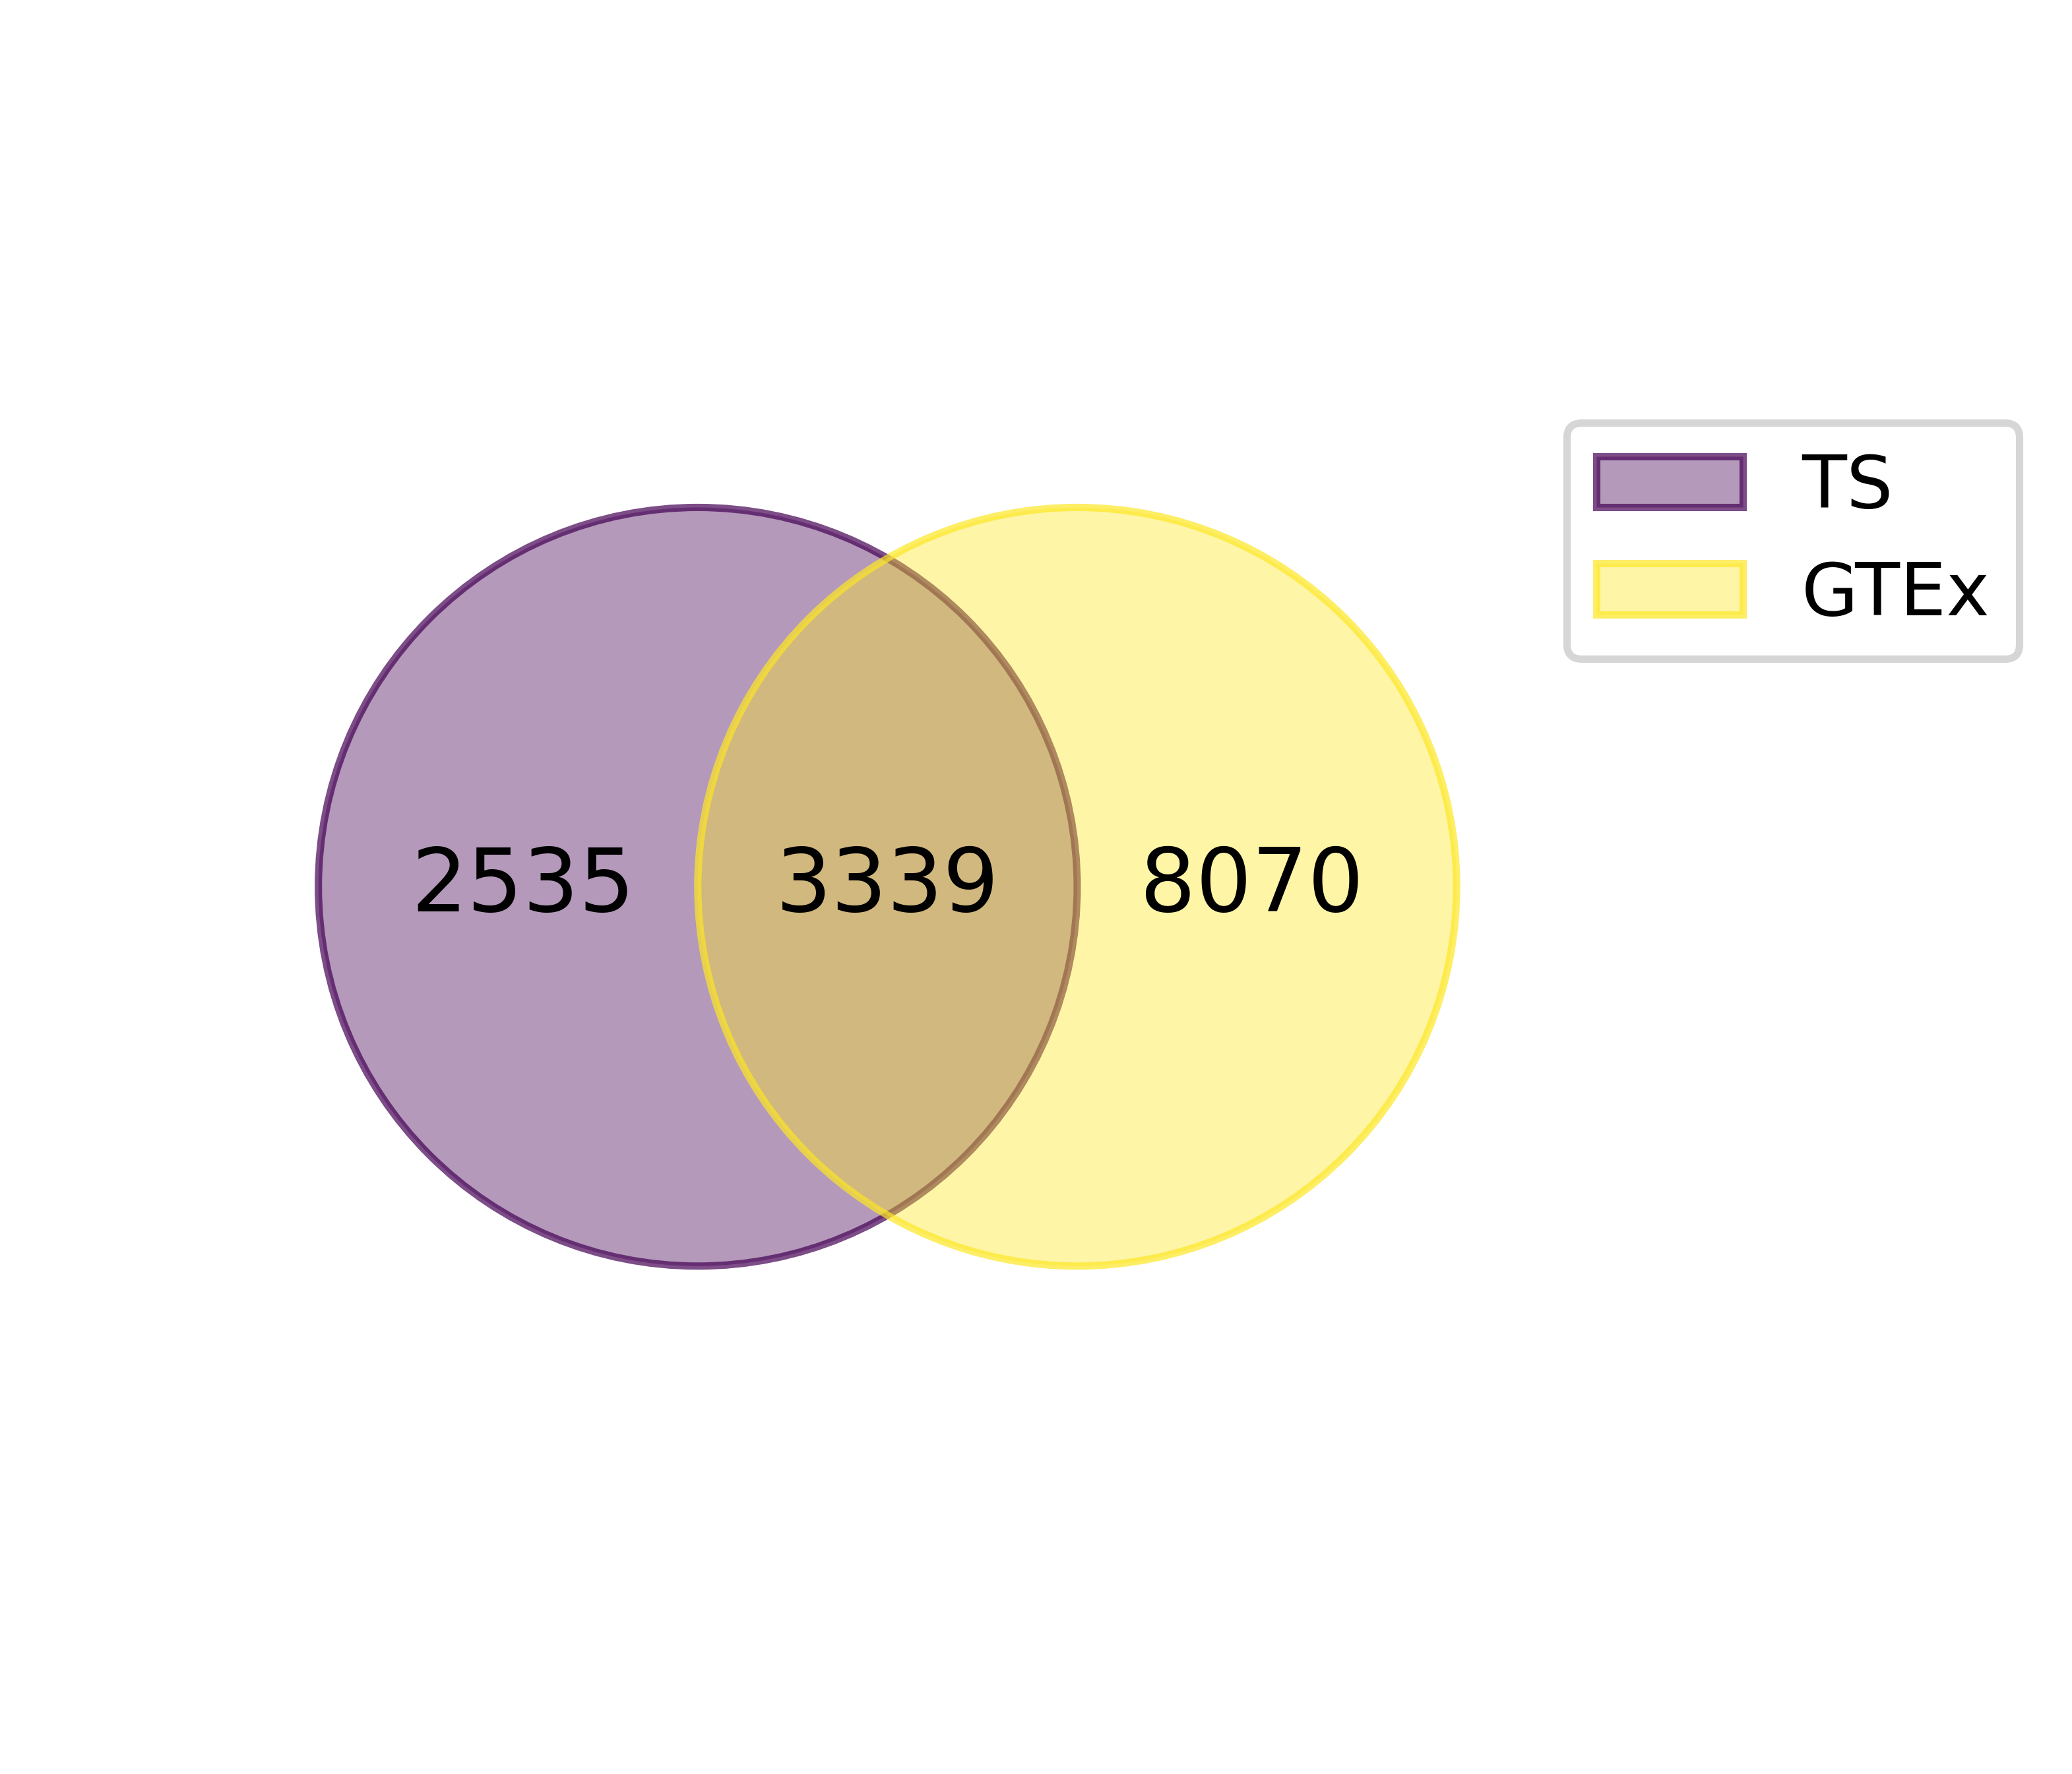

In [32]:
plot_venn(TS_gene = set(np.intersect1d(list(TS_data_tissue_df.index.unique()), list(union_genes))),
                       GTEx_gene = set(np.intersect1d(list(GTEx_data_df.index.unique()), list(union_genes))), 
                      )

In [33]:
def plot_bar(mapping_dict,TS_data,GTEx_data,gene_shared):
    
    
    data_plot_all = [] 
    genes_in_GTEX_notin_TS_all = {}
    for tissue_ in mapping_dict.keys():
        print(tissue_)
        TS_DEG_tissue = TS_data[TS_data['tissue']==tissue_]
        TS_DEG_set = set(TS_DEG_tissue.index)
        TS_DEG_set = TS_DEG_set & gene_shared

        # search gene list in gtex
        corres_gtex_tissue = mapping_dict[tissue_]

        union_genes_Gtex = set()
        for corres_gtex_tissue_ in corres_gtex_tissue:
            gtex_de_ = GTEx_data[['effsize','lfsr','tissue_rename']] #[(gtex_de['logFC']>=1) | (gtex_de['logFC']<=-1)]
            gtex_de_.index = GTEx_data['gene_symbol']
            gtex_de_tissue = gtex_de_[gtex_de_['tissue_rename']==corres_gtex_tissue_]
            union_genes_Gtex = union_genes_Gtex.union(set(gtex_de_tissue.index))

        union_genes_Gtex = union_genes_Gtex & gene_shared

        #TS_DEG_set_new = [i for i in TS_DEG_set if len(TS_DEG_tissue.loc[[i]]['cell_type'].unique())>1]

        intersect_gene = set(TS_DEG_set) & union_genes_Gtex

        genes_in_GTEX_notin_TS_all[tissue_] = list(union_genes_Gtex-TS_DEG_set)
        data_plot_all.append([tissue_, 
                              len(TS_DEG_set), 
                              len(union_genes_Gtex), 
                              len(intersect_gene),
                            
                             ]
                            )

    data_plot_all = pd.DataFrame(data_plot_all,columns=['Tissue',
                                                        'DE identified in TS',
                                                        'DE identified in GTex',
                                                        'Overlapped DE between TS and GTex',
                                                       
                                                       ])    

    data_plot_all['percent in TS'] = data_plot_all['Overlapped DE between TS and GTex']/data_plot_all['DE identified in TS']*100
    data_plot_all['percent in GTex'] = data_plot_all['Overlapped DE between TS and GTex']/data_plot_all['DE identified in GTex']*100

    hex_colors = ['#3145a8', '#40a8f7', '#f5bf36','#fa2616']
    cmap = ['#ffbe4f', '#0ea7b5', '#0c457d','#e8702a']
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(5, 2
                                   ), dpi=800)

    # Plotting
    ax.bar(data_plot_all['Tissue'], 
           data_plot_all['DE identified in TS'],#-data_plot_all['Overlapped DE between TS and GTex'], 
           label='DE identified in TS',
           color='#3145a8',
           alpha=0.4
          )


    ax.bar(data_plot_all['Tissue'], 
           data_plot_all['DE identified in GTex'], 
           bottom=data_plot_all['DE identified in TS']-data_plot_all['Overlapped DE between TS and GTex'], 
           label='DE identified in GTex', 
           color='#f5bf36',
           alpha=0.4
          )

    # Additional customizations
    ax.set_xlabel('Tissue')
    ax.set_ylabel('Number of sex-biased DE genes (FDR<0.05)')
    ax.set_xticks(data_plot_all['Tissue'])
    ax.set_xticklabels(data_plot_all['Tissue'], rotation=90)
    ax.legend(bbox_to_anchor=(1, 0.8))

    # Hide top and right axis lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Show the plot
    plt.show()
    return data_plot_all

In [34]:
mapping_dict = {'Fat':['ADPSBQ','ADPVSC'],
                'Spleen':['SPLEEN'],
                'Salivary_Gland':['SLVRYG'],
                #'Lung':['LUNG'],
                'Blood':['WHLBLD'],
                'Skin':['SKINNS','SKINS'],
                #'Small_Intestine':['SNTTRM'],
                'Muscle':['MSCLSK'],
                'Vasculature':['ARTTBL','ARTAORT','ARTCRN'],
                'Heart':['HRTAA','HRTLV'],
                #'Large_Intestine':['CLNSGM','CLNTRN']
}

Fat
Spleen
Salivary_Gland
Blood
Skin
Muscle
Vasculature
Heart


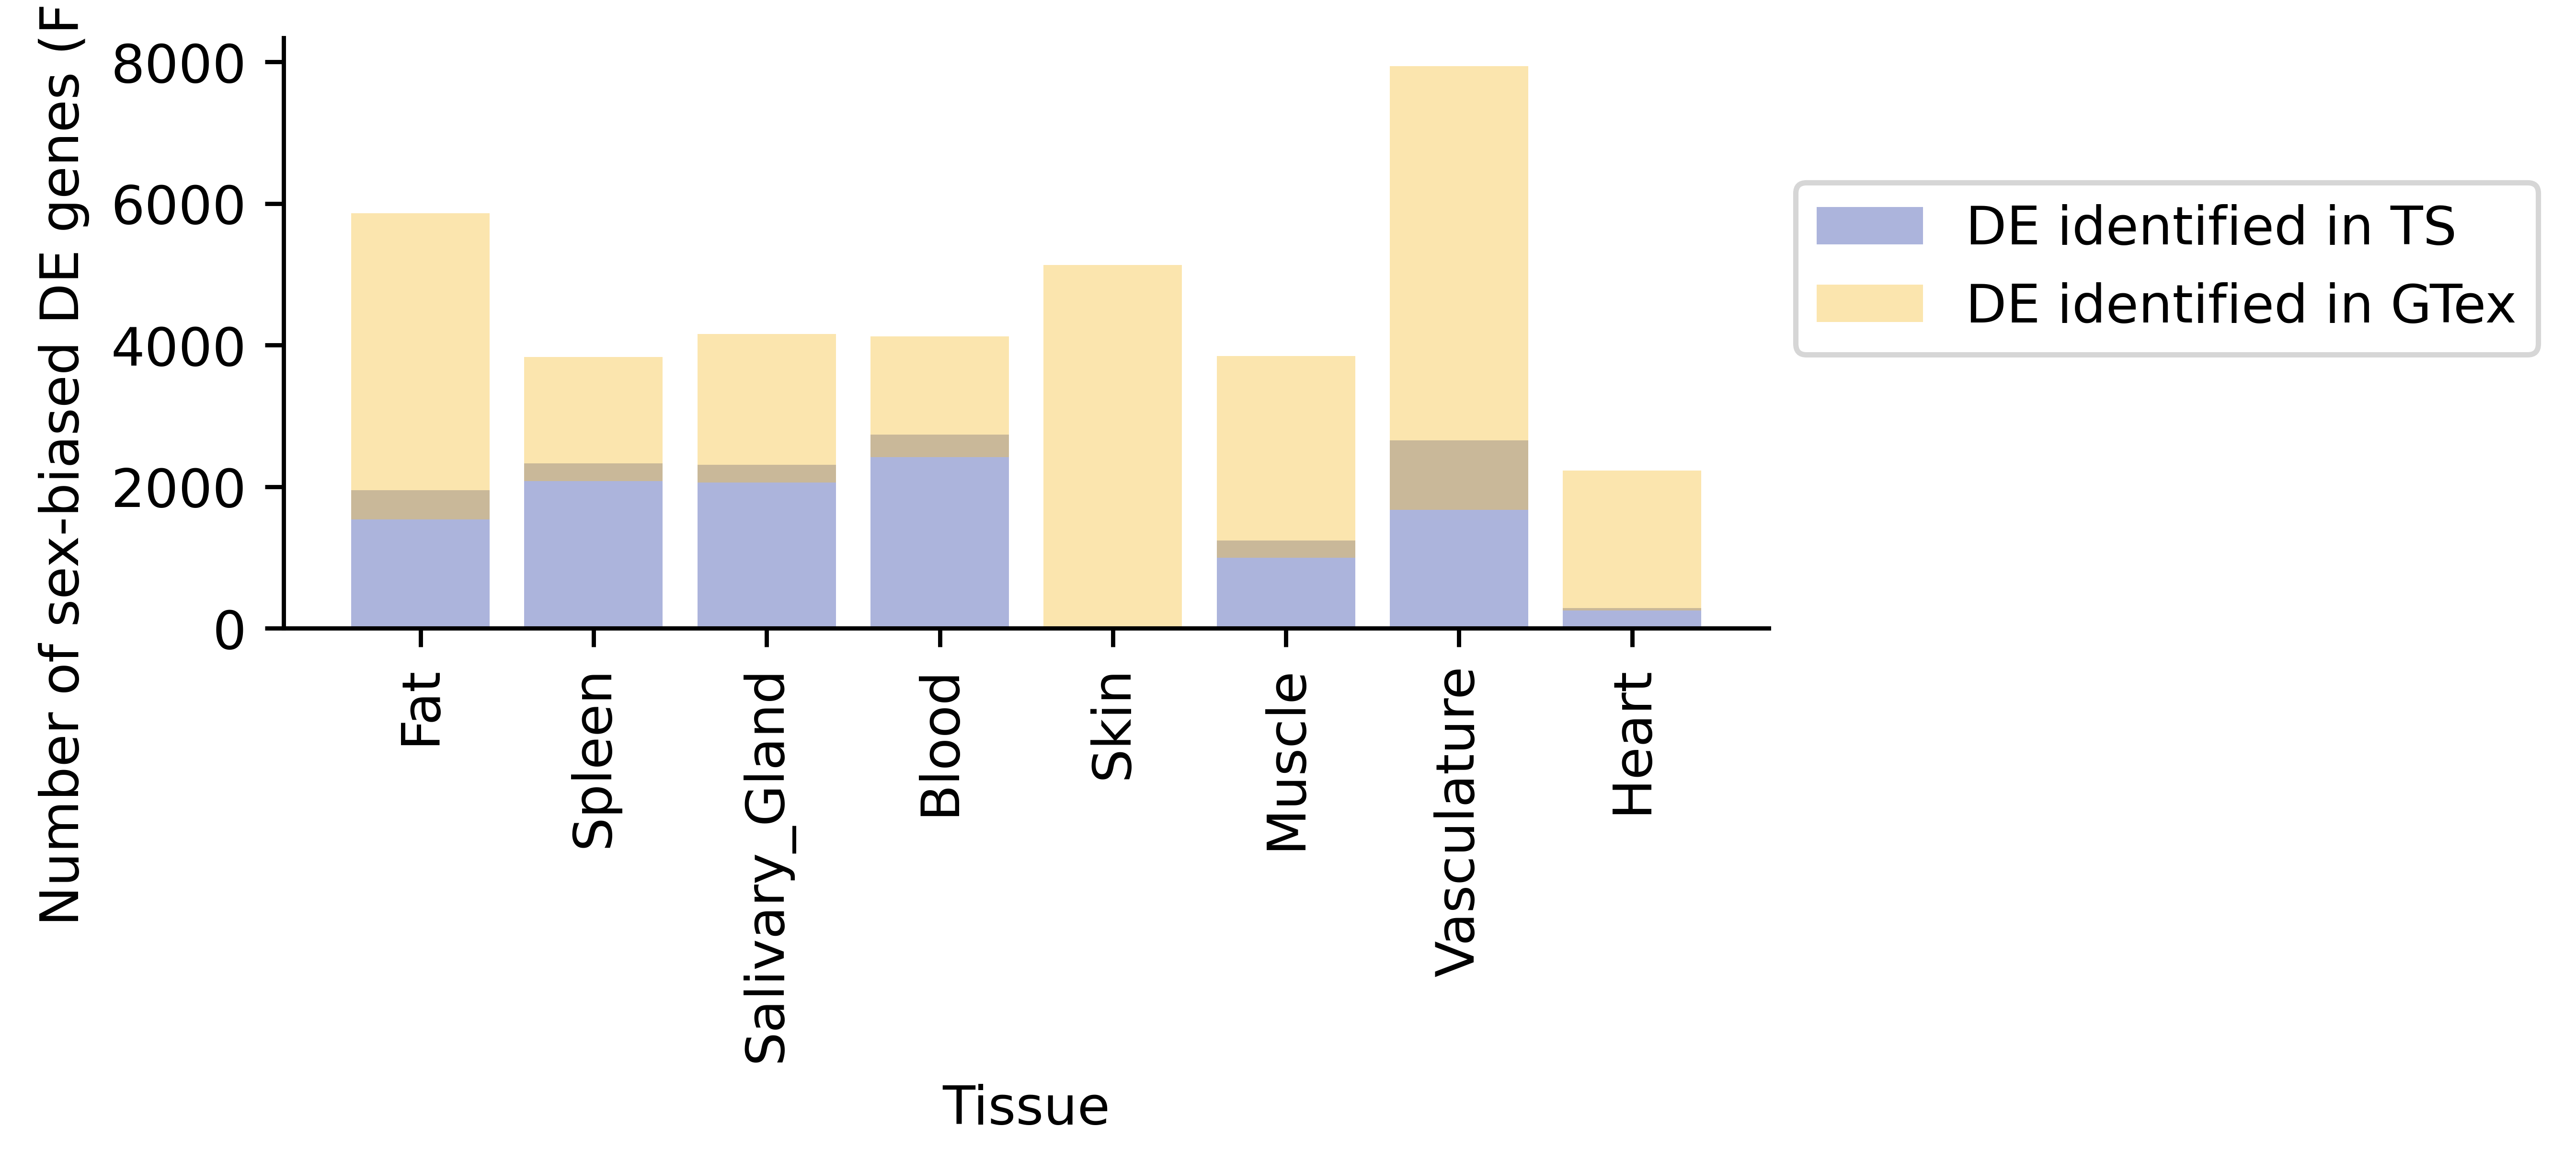

,Tissue,DE identified in TS,DE identified in GTex,Overlapped DE between TS and GTex,percent in TS,percent in GTex
0,Fat,1949,4325,408,20.933812,9.433526
1,Spleen,2327,1753,247,10.614525,14.090131
2,Salivary_Gland,2311,2101,253,10.947642,12.041885
3,Blood,2738,1702,317,11.577794,18.625147
4,Skin,0,5130,0,NaN,0.000000
5,Muscle,1239,2849,243,19.612591,8.529309
6,Vasculature,2657,6270,986,37.109522,15.725678
7,Heart,286,1981,37,12.937063,1.867744


In [35]:
plot_bar(mapping_dict,
         TS_data_df,
      GTEx_data_df,
      union_genes,

         )

In [36]:
set(GTEx_data_df[GTEx_data_df['chr']=='chrX'].index.unique()) - set(TS_data_df[TS_data_df['chr']=='chrX'].index.unique())

{'AARSD1P1',
 'ADGRG2',
 'ADGRG4',
 'AIFM1',
 'APLN',
 'APOO',
 'ARMCX4',
 'ARSF',
 'ARSH',
 'ASB12',
 'ATG4A',
 'ATP6AP2',
 'ATP7A',
 'BRCC3',
 'C1GALT1C1',
 'CACNA1F',
 'CCDC120',
 'CCDC160',
 'CCNB3',
 'CDK16',
 'CENPI',
 'CHIC1',
 'CSTF2',
 'CXorf65',
 'DCAF12L1',
 'DCAF12L2',
 'DLG3',
 'DYNLT3',
 'EEF1GP5',
 'ENSG00000183171',
 'ENSG00000212663',
 'ENSG00000227329',
 'ENSG00000236393',
 'ENSG00000271199',
 'FGF13-AS1',
 'FOXO4',
 'FOXP3',
 'FUNDC1',
 'GPKOW',
 'GPR143',
 'GPR173',
 'HDAC6',
 'HDAC8',
 'HSFX1',
 'HSFX2',
 'IRS4-AS1',
 'KANTR',
 'KDM5C-IT1',
 'KLF8',
 'L1CAM',
 'LANCL3',
 'LAS1L',
 'LINC02601',
 'MAGEE2',
 'MAGIX',
 'MAGT1',
 'MCTS1',
 'MORC4',
 'MOSPD1',
 'MRFAP1P1',
 'MTM1',
 'MTND4P24',
 'NAP1L2',
 'NAP1L6P',
 'NLGN3',
 'NSDHL',
 'NUDT10',
 'NUDT11',
 'NUP62CL',
 'NXT2',
 'OTC',
 'OTUD5',
 'PABPC1L2A',
 'PAGE4',
 'PDHA1',
 'PDZD11',
 'PHEX-AS1',
 'PHF10P1',
 'PLXNB3',
 'PNMA6B',
 'POF1B',
 'PQBP1',
 'PRPS2',
 'PSMD10',
 'RAB9B',
 'RAI2',
 'RBM10',
 'RHOXF1',
 'RH

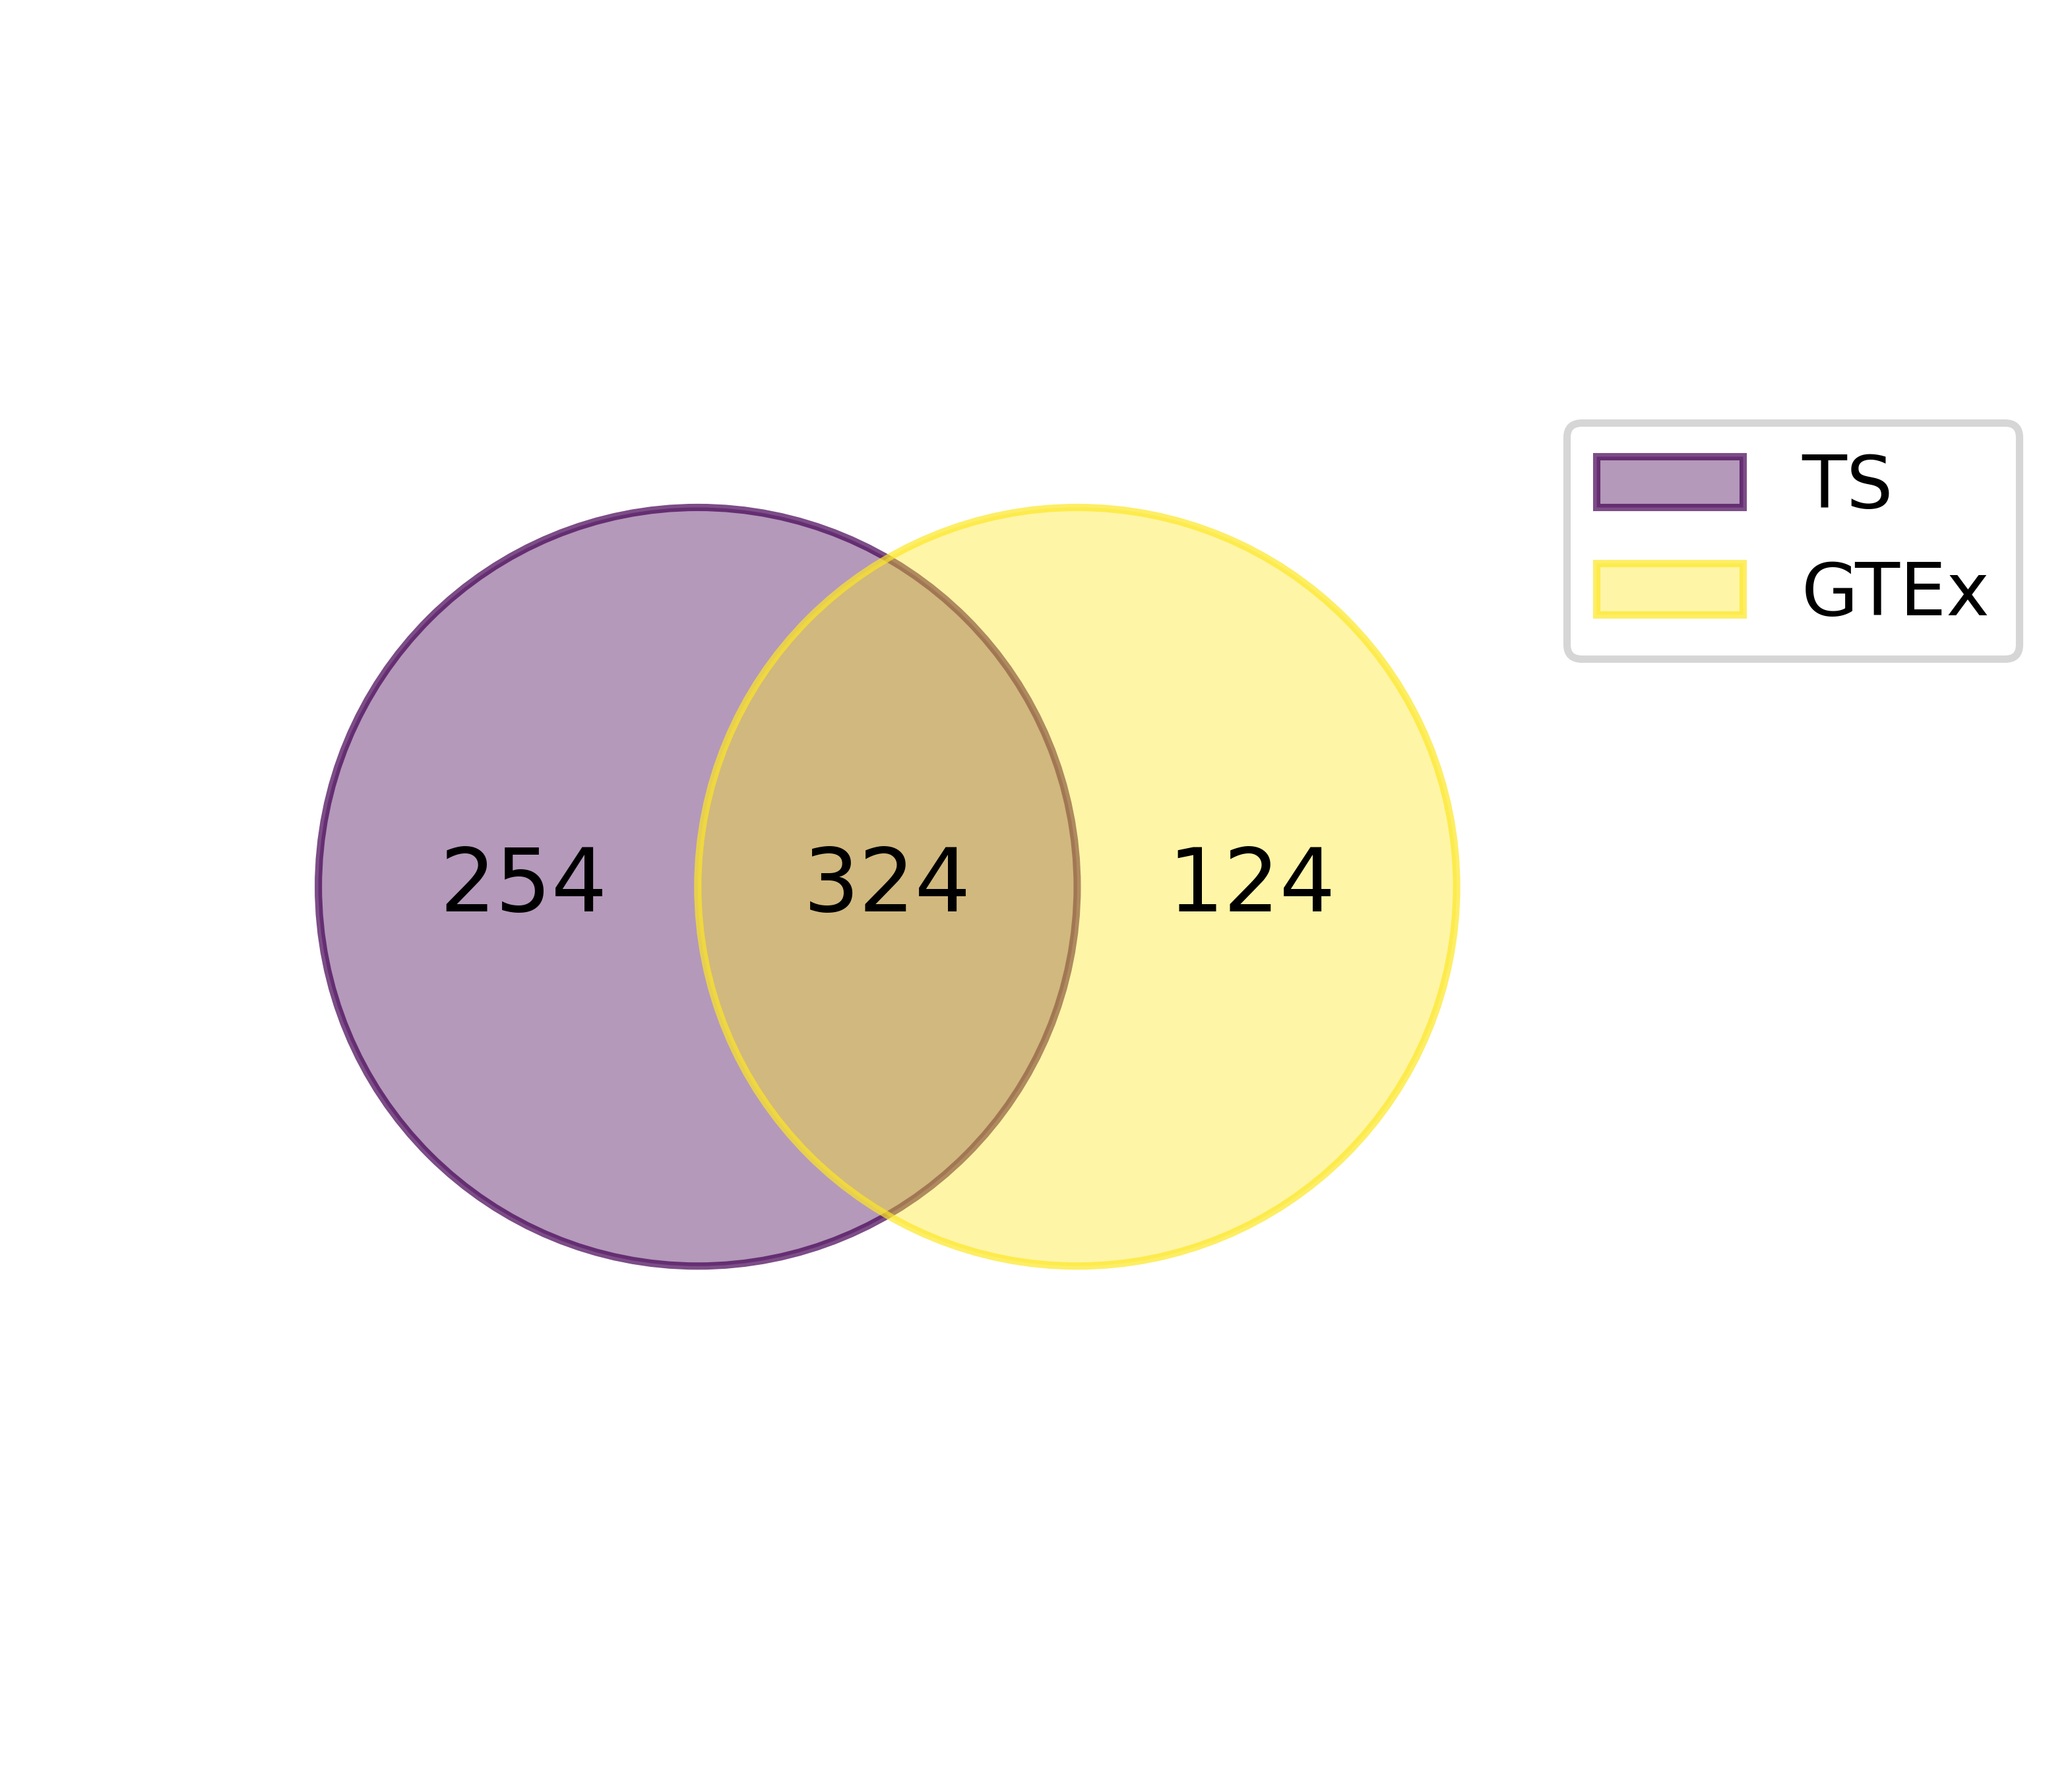

In [37]:
plot_venn(TS_gene = set(TS_data_df[TS_data_df['chr']=='chrX'].index.unique()),
          GTEx_gene = set(GTEx_data_df[GTEx_data_df['chr']=='chrX'].index.unique()), 
                      )

In [38]:
mapping_dict_reverse = {
 'ADPSBQ': 'Fat',
 'ADPVSC': 'Fat',
 'SPLEEN': 'Spleen',
 'SLVRYG': 'Salivary_Gland',
 #'LUNG': 'Lung',
 'WHLBLD': 'Blood',
 'SKINNS': 'Skin',
 'SKINS': 'Skin',
 #'SNTTRM': 'Small_Intestine',
 'MSCLSK': 'Muscle',
 'ARTTBL': 'Vasculature',
 'ARTAORT': 'Vasculature',
 'ARTCRN': 'Vasculature',
 'HRTAA': 'Heart',
 'HRTLV': 'Heart',
 #'CLNSGM': 'Large_Intestine',
 #'CLNTRN': 'Large_Intestine'
}
GTEx_data_df['tissue_TS'] = GTEx_data_df['tissue_rename'].map(mapping_dict_reverse)

In [39]:
TS_X_gene_percent = []
for i in TS_data_df[TS_data_df['chr']=='chrX'].index.unique():
    temp = TS_data_df.loc[[i],:]
    TS_X_gene_percent.append([i,len(temp['tissue'].unique())/11,temp['logFC'].mean()])
    
    
GTEx_X_gene_percent = []
for i in GTEx_data_df[GTEx_data_df['chr']=='chrX'].index.unique():
    temp = GTEx_data_df.loc[[i],:]
    GTEx_X_gene_percent.append([i,len(temp['tissue_TS'].unique())/11,temp['effsize'].mean()])
    
TS_X_gene_percent = pd.DataFrame(TS_X_gene_percent,columns=['gene','percentage','logFC_mean'])
GTEx_X_gene_percent = pd.DataFrame(GTEx_X_gene_percent,columns=['gene','percentage','logFC_mean'])

In [40]:
4932/(4932+6248)

0.4411449016100179

In [41]:

TS_X_gene_percent[TS_X_gene_percent['percentage']>0.6].sort_values(by='logFC_mean')

,gene,percentage,logFC_mean
94,DDX3X,0.636364,0.758832
252,JPX,0.636364,0.929481
256,KDM6A,0.636364,1.046279
395,RBM3,0.636364,1.137965
525,TSIX,0.636364,5.041529
556,XIST,0.636364,9.613176


In [42]:
GTEx_X_gene_percent[GTEx_X_gene_percent['percentage']>0.8].sort_values(by='logFC_mean')

,gene,percentage,logFC_mean
171,IKBKG,0.818182,-0.031524
386,TMEM187,0.818182,0.074355
273,PIN4,0.818182,0.075690
57,CDK16,0.818182,0.076860
10,ALG13,0.818182,0.077210
61,CHM,0.818182,0.092821
234,NAA10,0.818182,0.106076
77,CXorf38,0.818182,0.109669
137,FUNDC1,0.818182,0.111415
410,USP9X,0.818182,0.138543


In [43]:
GTEx_X_gene_percent['percentage']

0      0.636364
1      0.272727
2      0.363636
3      0.090909
4      0.090909
         ...   
443    0.272727
444    0.545455
445    0.090909
446    0.818182
447    0.181818
Name: percentage, Length: 448, dtype: float64

(0.0, 1.1)

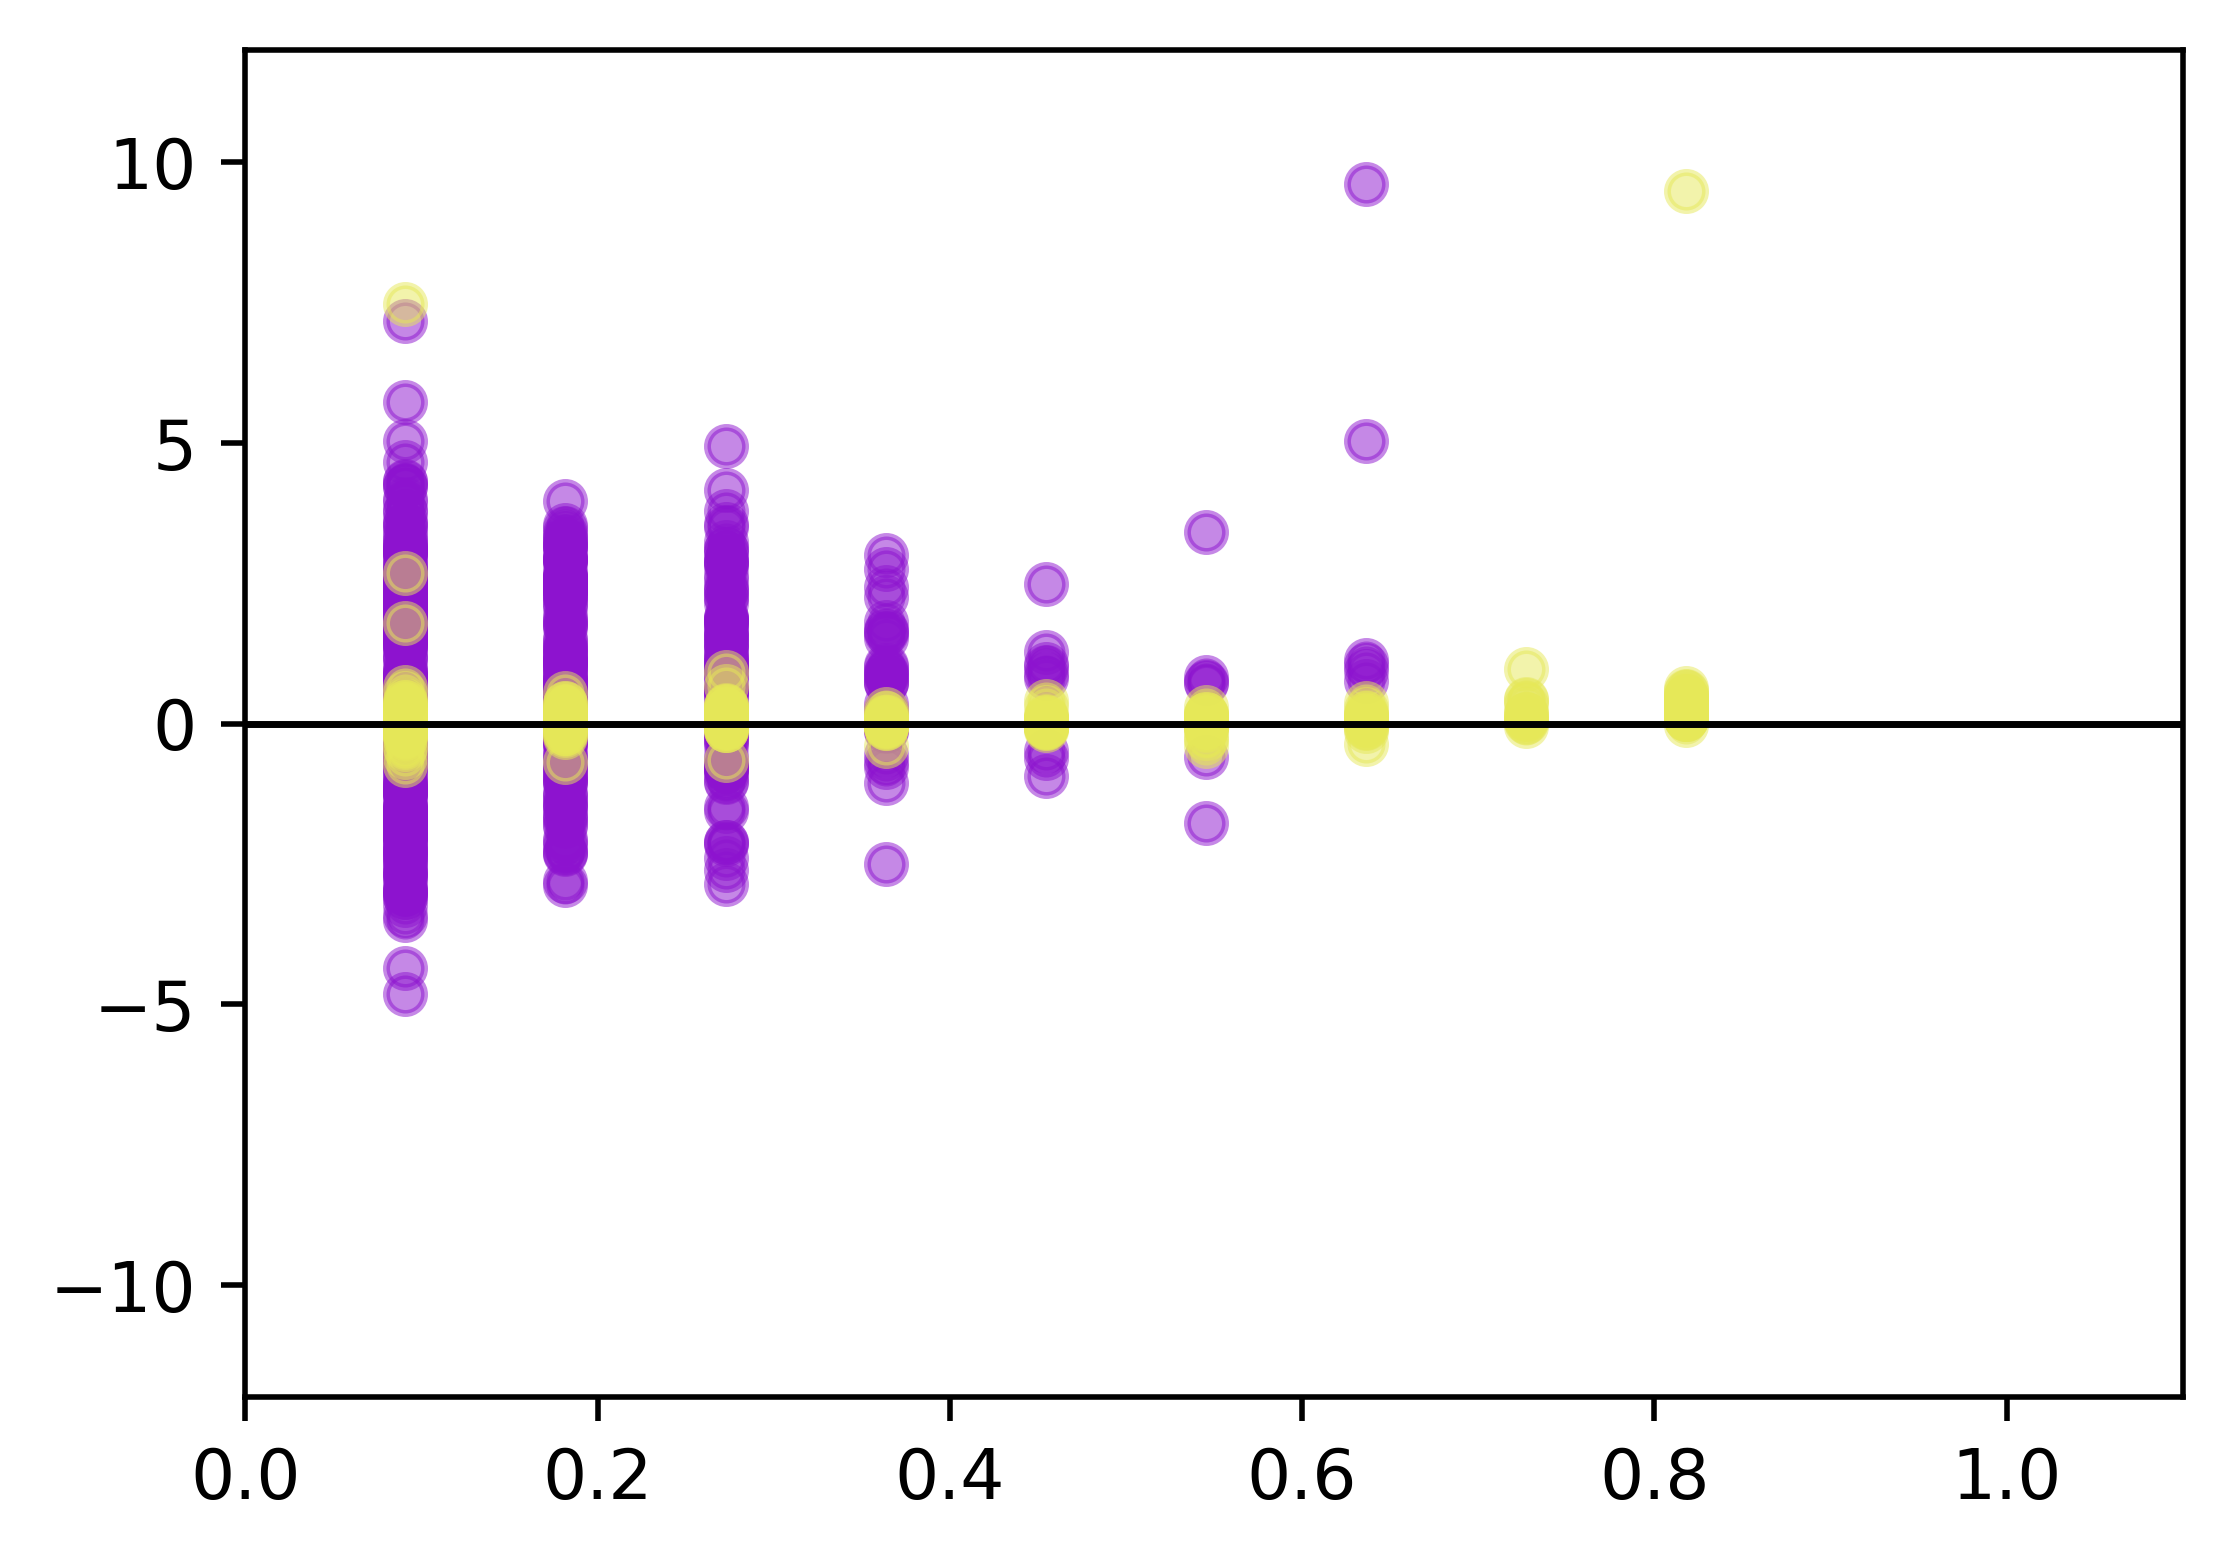

In [44]:
plt.figure(dpi=500,figsize=(5,3.5))
plt.scatter(TS_X_gene_percent['percentage'],TS_X_gene_percent['logFC_mean'],s=30,c='#8d13cf',alpha=0.5)
plt.scatter(GTEx_X_gene_percent['percentage'],GTEx_X_gene_percent['logFC_mean'],s=30,c='#e6e858',alpha=0.5)
plt.hlines(y=0,xmin=0,xmax=1.1,color='k',linewidth=1)
plt.ylim([-12,12])
plt.xlim([0,1.1])

In [56]:
TS_X_gene_percent[TS_X_gene_percent.percentage>=0.54].sort_values(by='logFC_mean',ascending=False)

,gene,percentage,logFC_mean
556,XIST,0.636364,9.613176
525,TSIX,0.636364,5.041529
290,MAP7D2,0.545455,3.413881
395,RBM3,0.636364,1.137965
256,KDM6A,0.636364,1.046279
252,JPX,0.636364,0.929481
255,KDM5C,0.545455,0.835256
94,DDX3X,0.636364,0.758832
109,EIF1AX,0.545455,0.746902
565,ZFX,0.545455,0.725198


In [47]:
    
def plot_fig1b(mapping_dict,GTEx_data):
    tissue_mtx = pd.DataFrame(np.zeros([len(mapping_dict.keys()),len(mapping_dict.keys())]))
    tissue_mtx.index = mapping_dict.keys()
    tissue_mtx.columns = mapping_dict.keys()
    for tissue_i in mapping_dict.keys():
        for tissue_j in mapping_dict.keys():
            tissue_mtx.loc[tissue_i, tissue_j] = len(set(GTEx_data[GTEx_data['tissue_rename'].isin(mapping_dict[tissue_i])].index)  & 
                                                     set(GTEx_data[GTEx_data['tissue_rename'].isin(mapping_dict[tissue_j])].index)
                                                                   )

    plt.subplots(1,1,dpi=600,figsize=(5,4))
    sns.heatmap(tissue_mtx,vmax=4000)

    

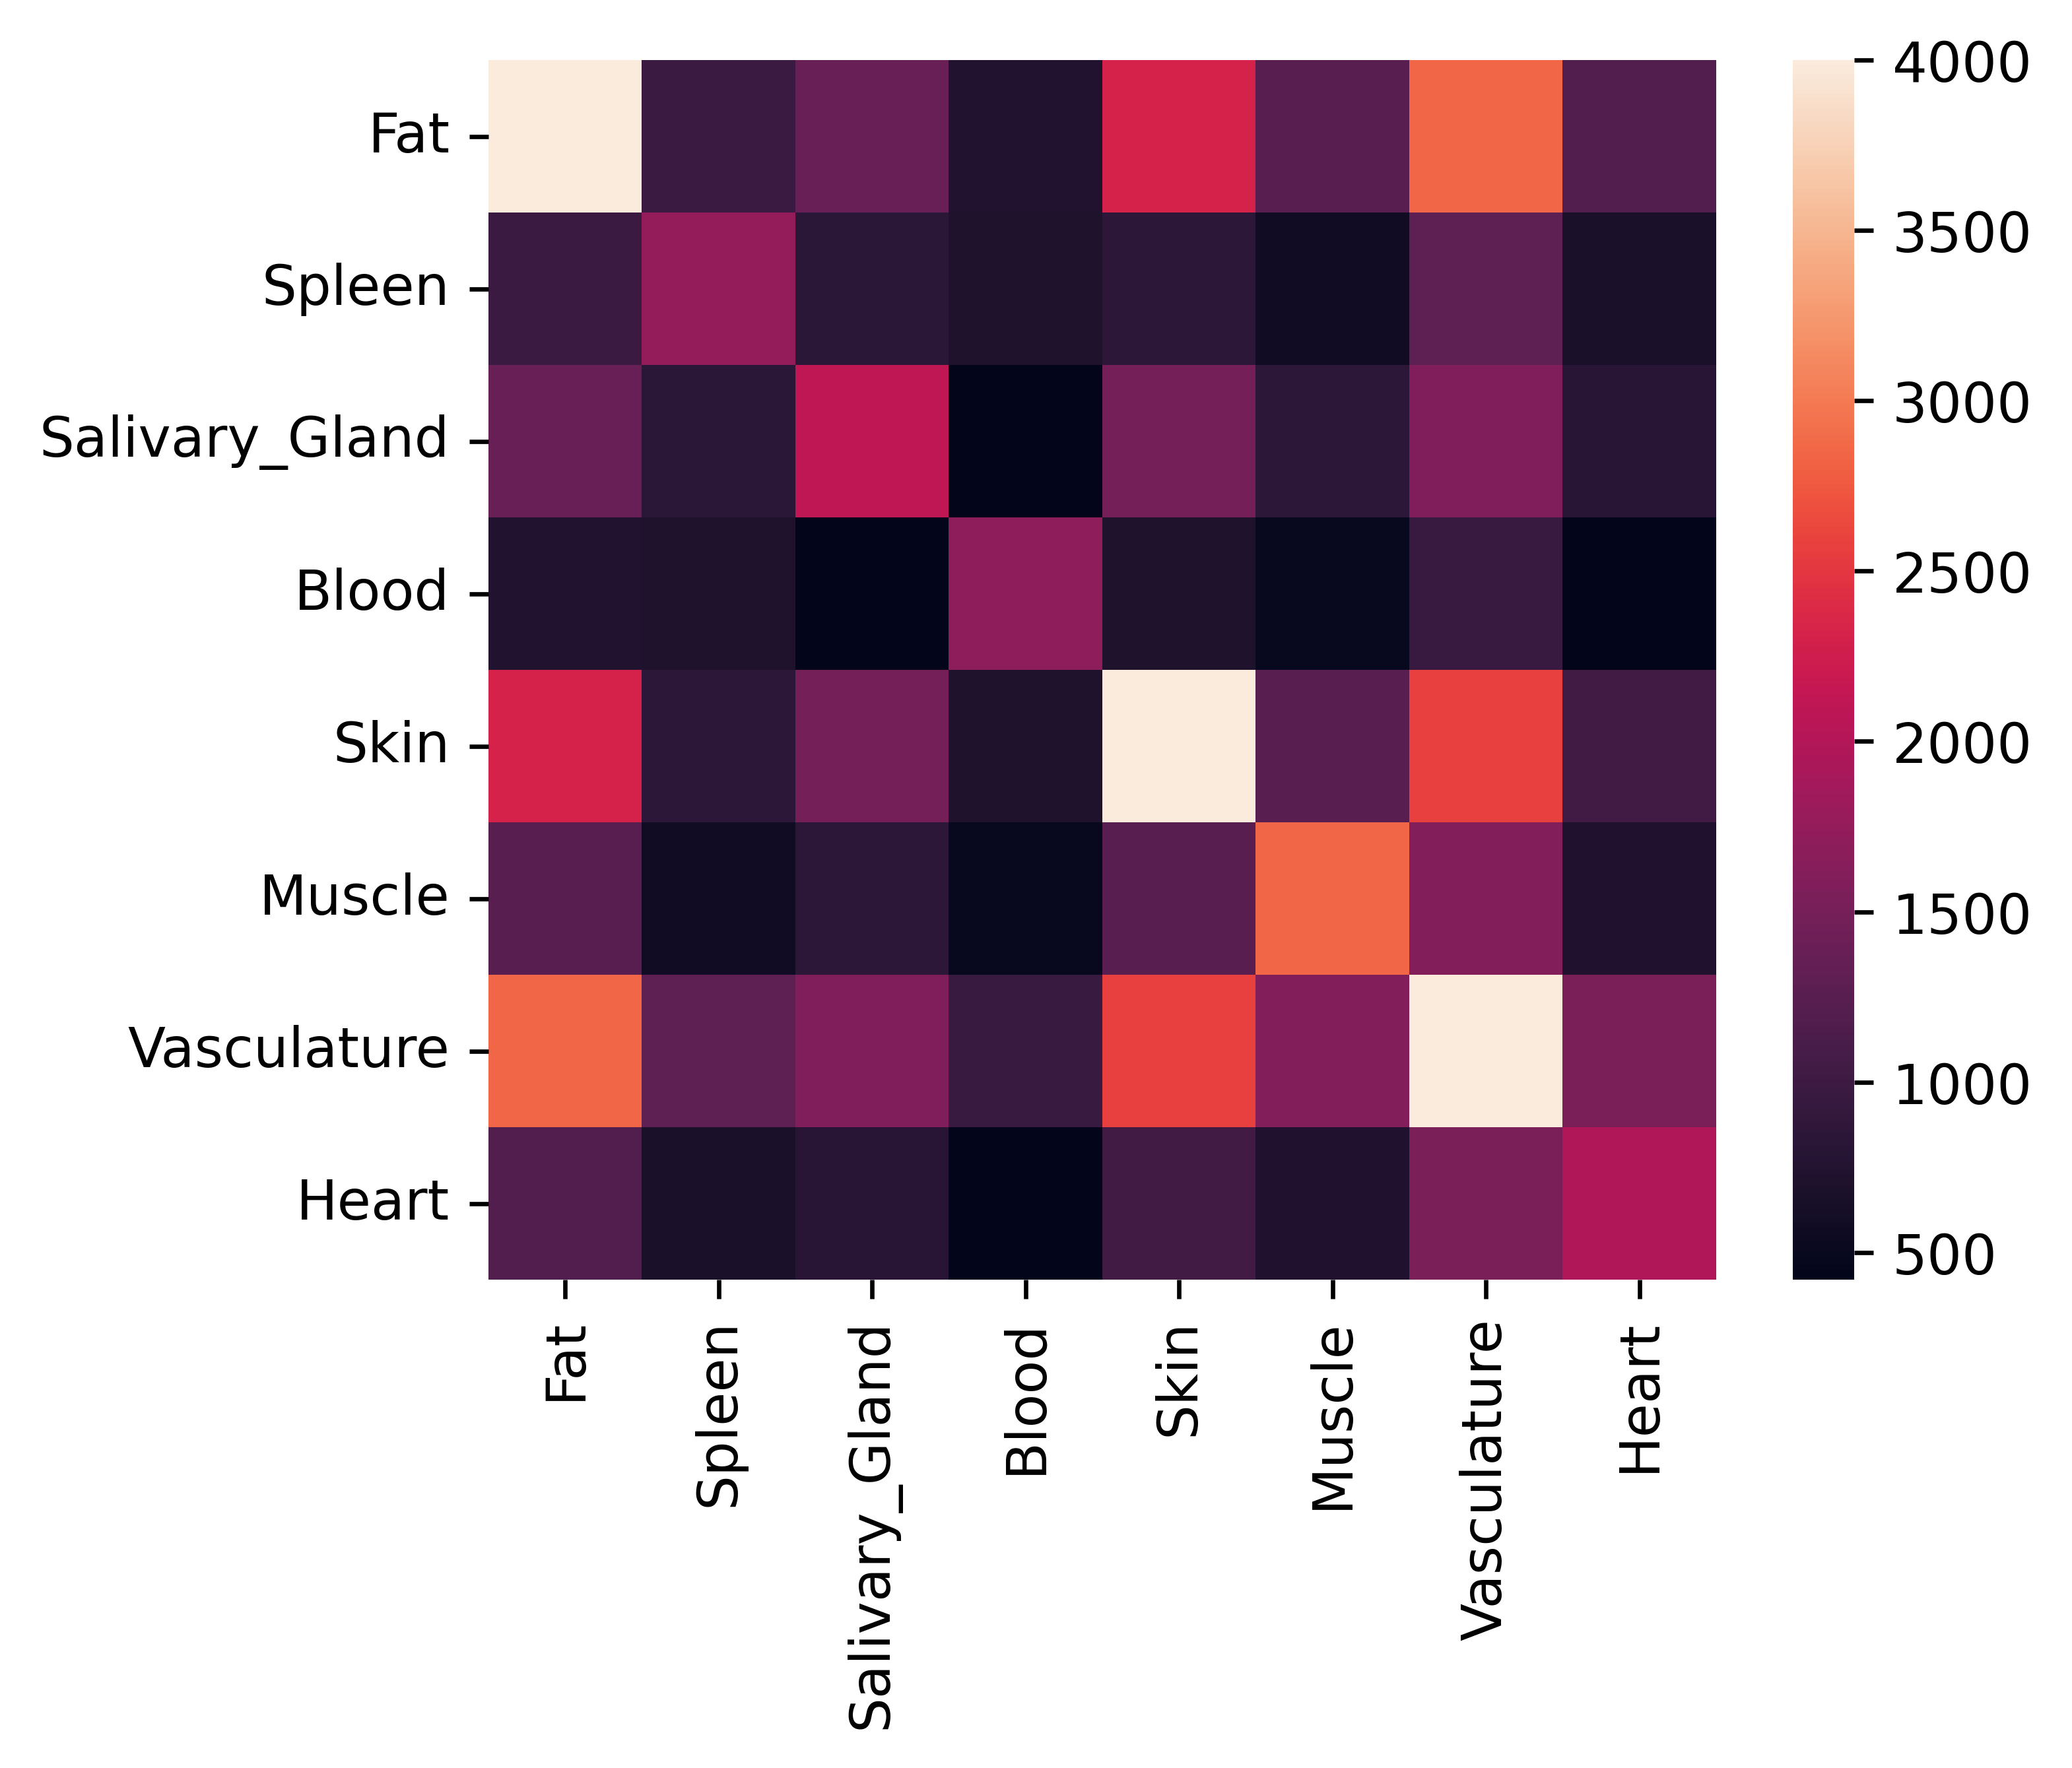

In [48]:
plot_fig1b(mapping_dict,GTEx_data_df)

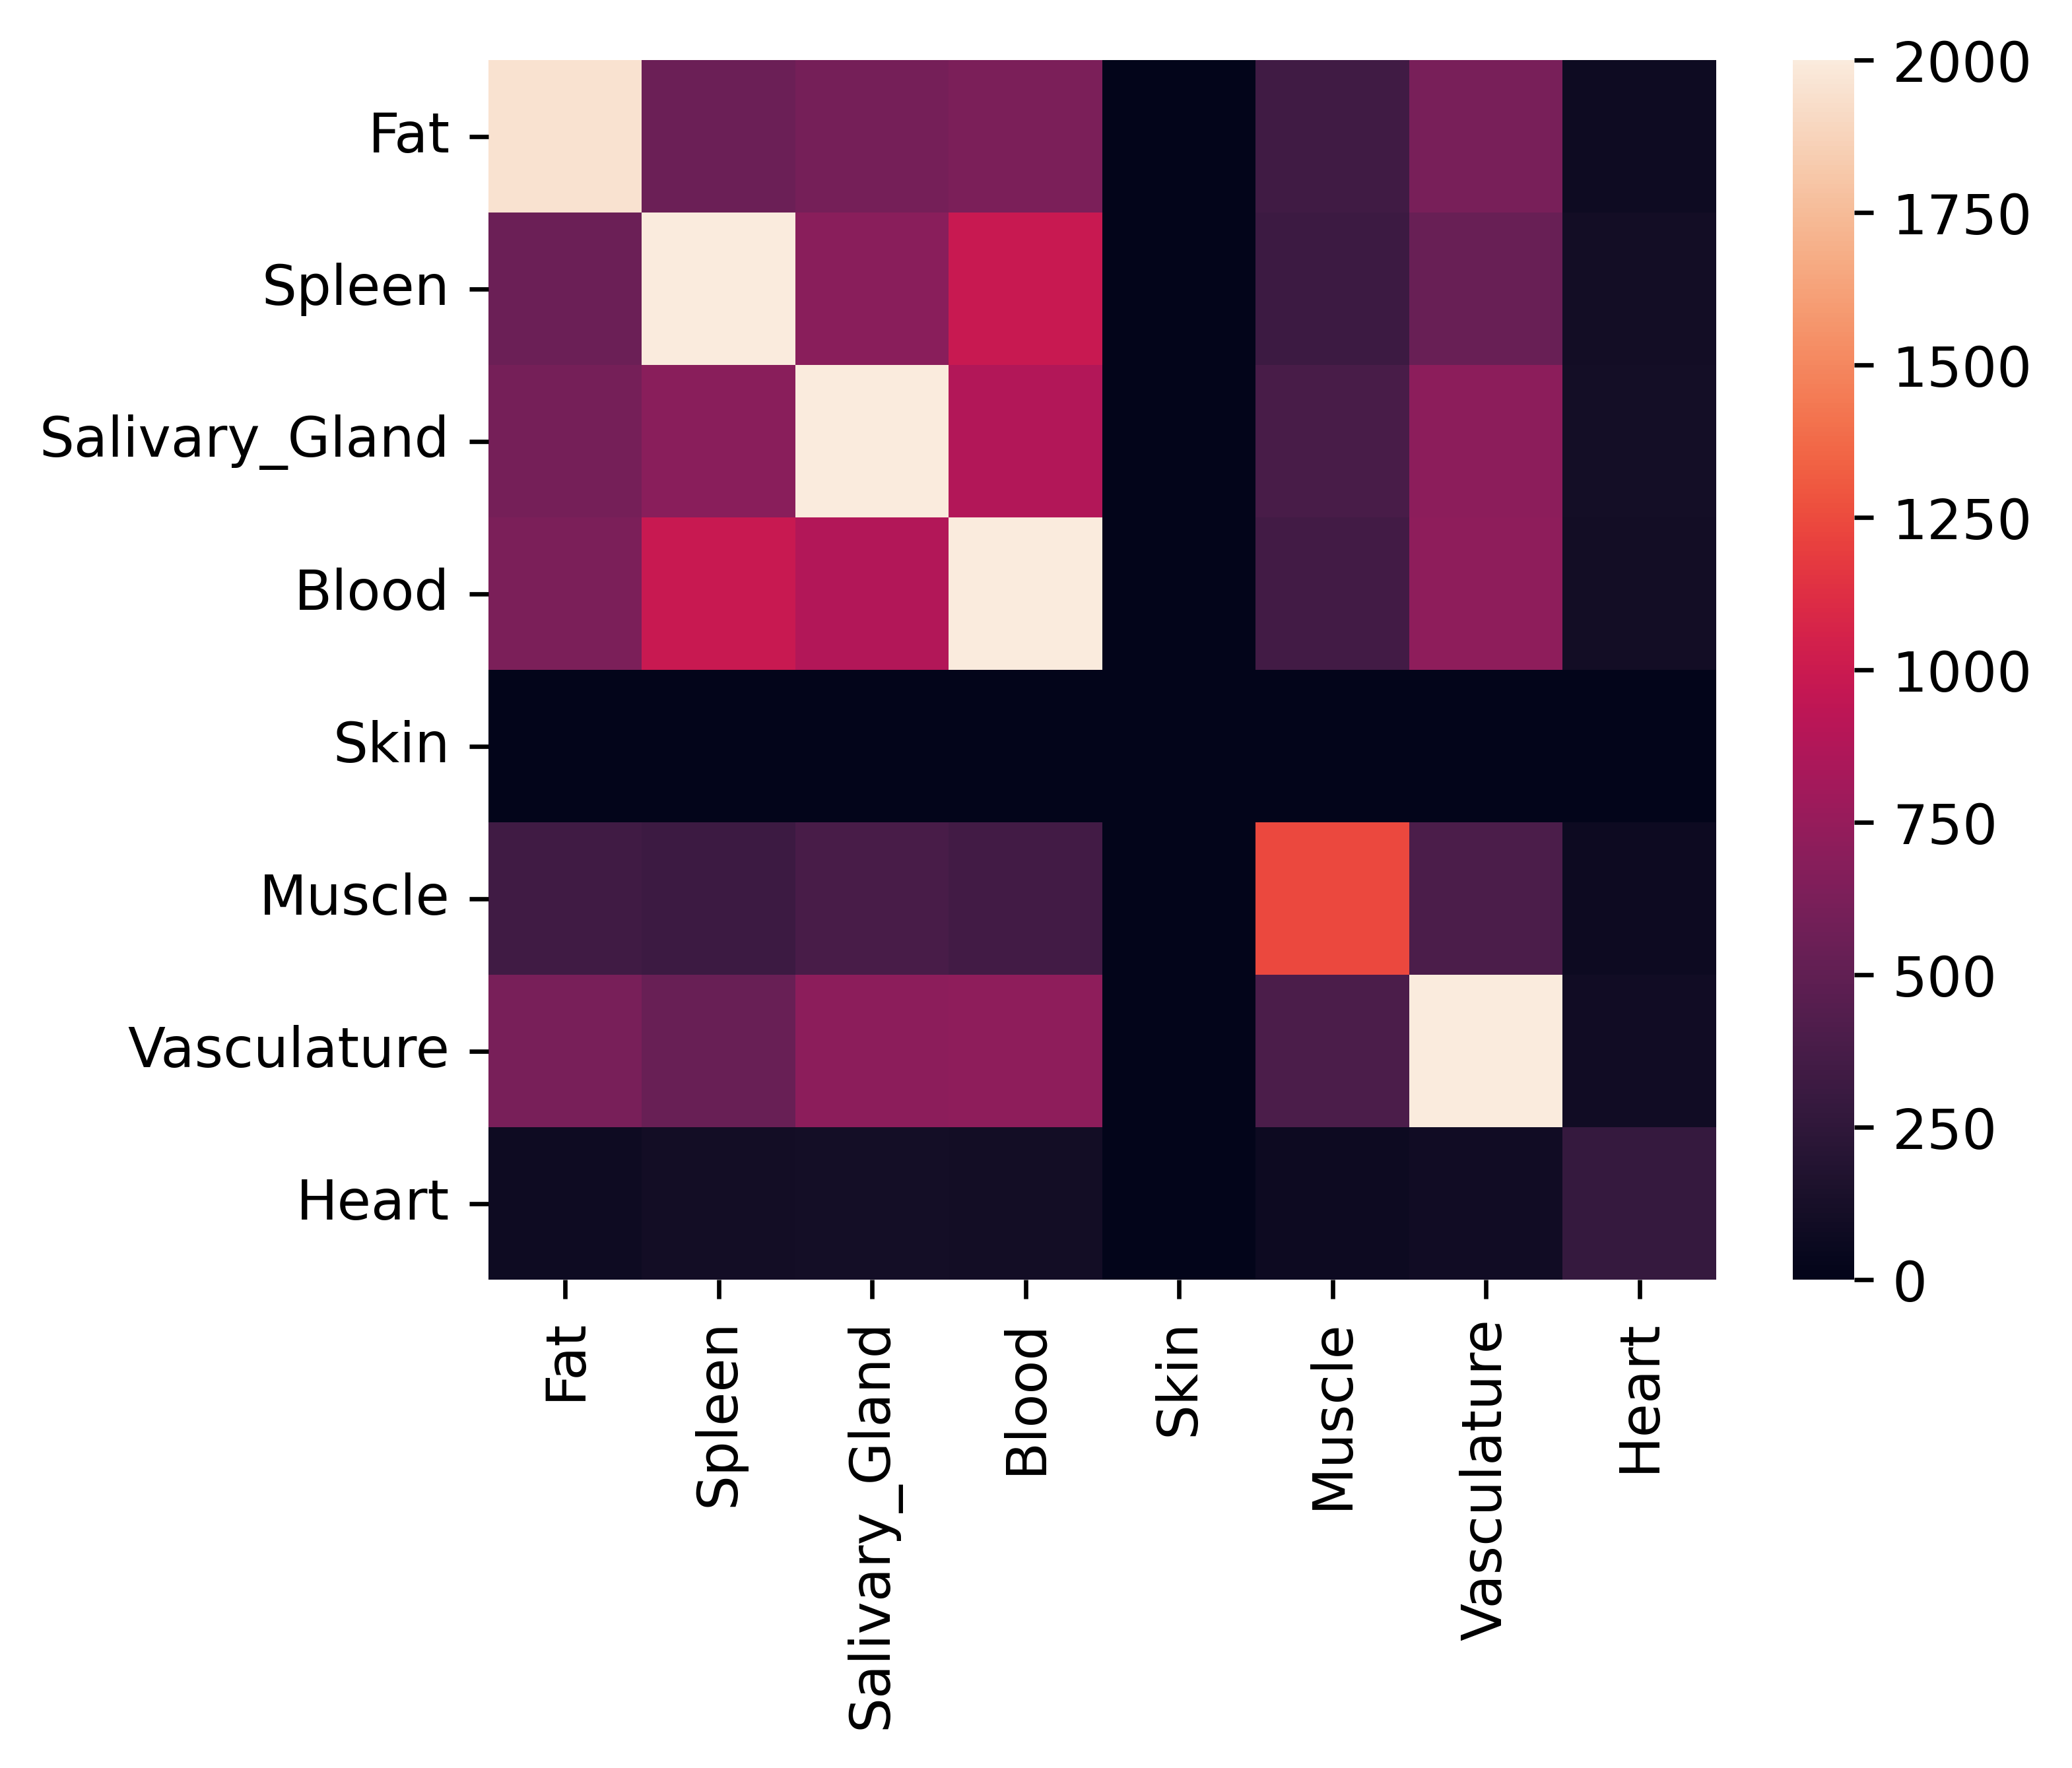

In [59]:
def plot_fig1b_2(mapping_dict,TS_data):
    tissue_mtx = pd.DataFrame(np.zeros([len(mapping_dict.keys()),len(mapping_dict.keys())]))
    tissue_mtx.index = mapping_dict.keys()
    tissue_mtx.columns = mapping_dict.keys()
    for tissue_i in mapping_dict.keys():
        for tissue_j in mapping_dict.keys():
            tissue_mtx.loc[tissue_i, tissue_j] = len(set(TS_data[TS_data['tissue']==tissue_i].index)  & 
                                                     set(TS_data[TS_data['tissue']==tissue_j].index)
                                                                   )

    plt.subplots(1,1,dpi=600,figsize=(5,4))
    sns.heatmap(tissue_mtx,vmax=2000)
plot_fig1b_2(mapping_dict,TS_data_df)

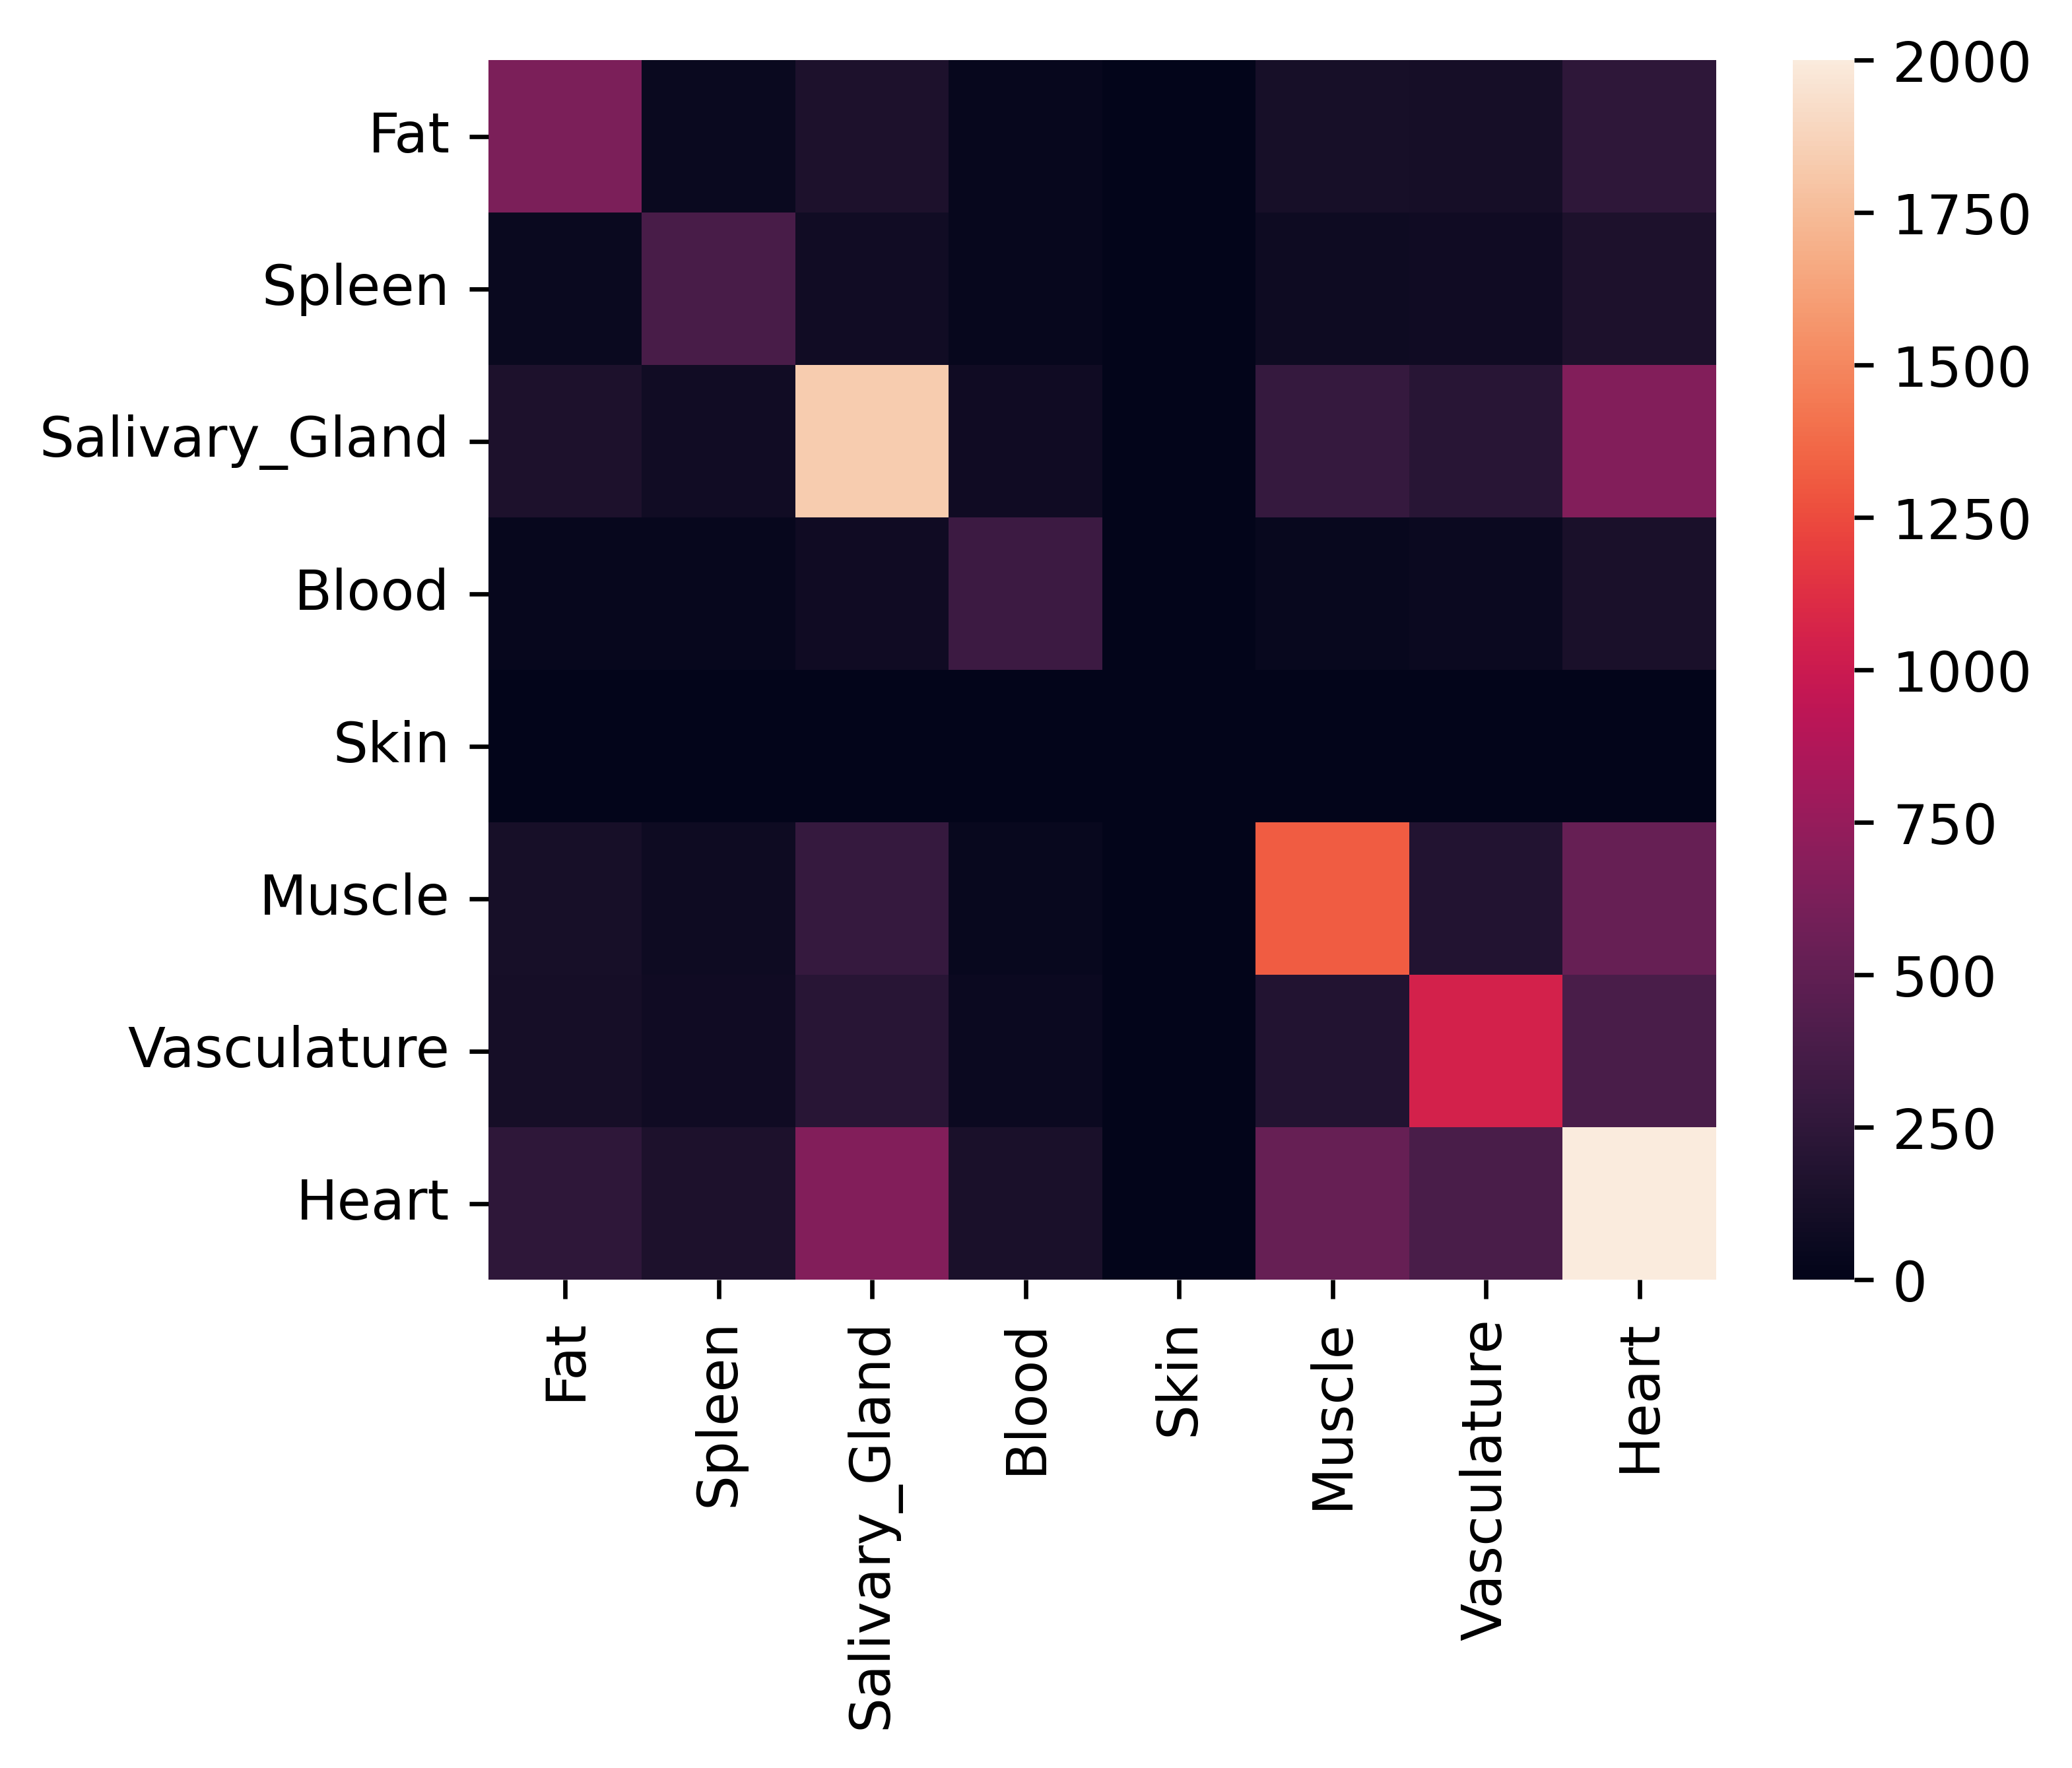

In [60]:
plot_fig1b_2(mapping_dict,TS_data_tissue_df)

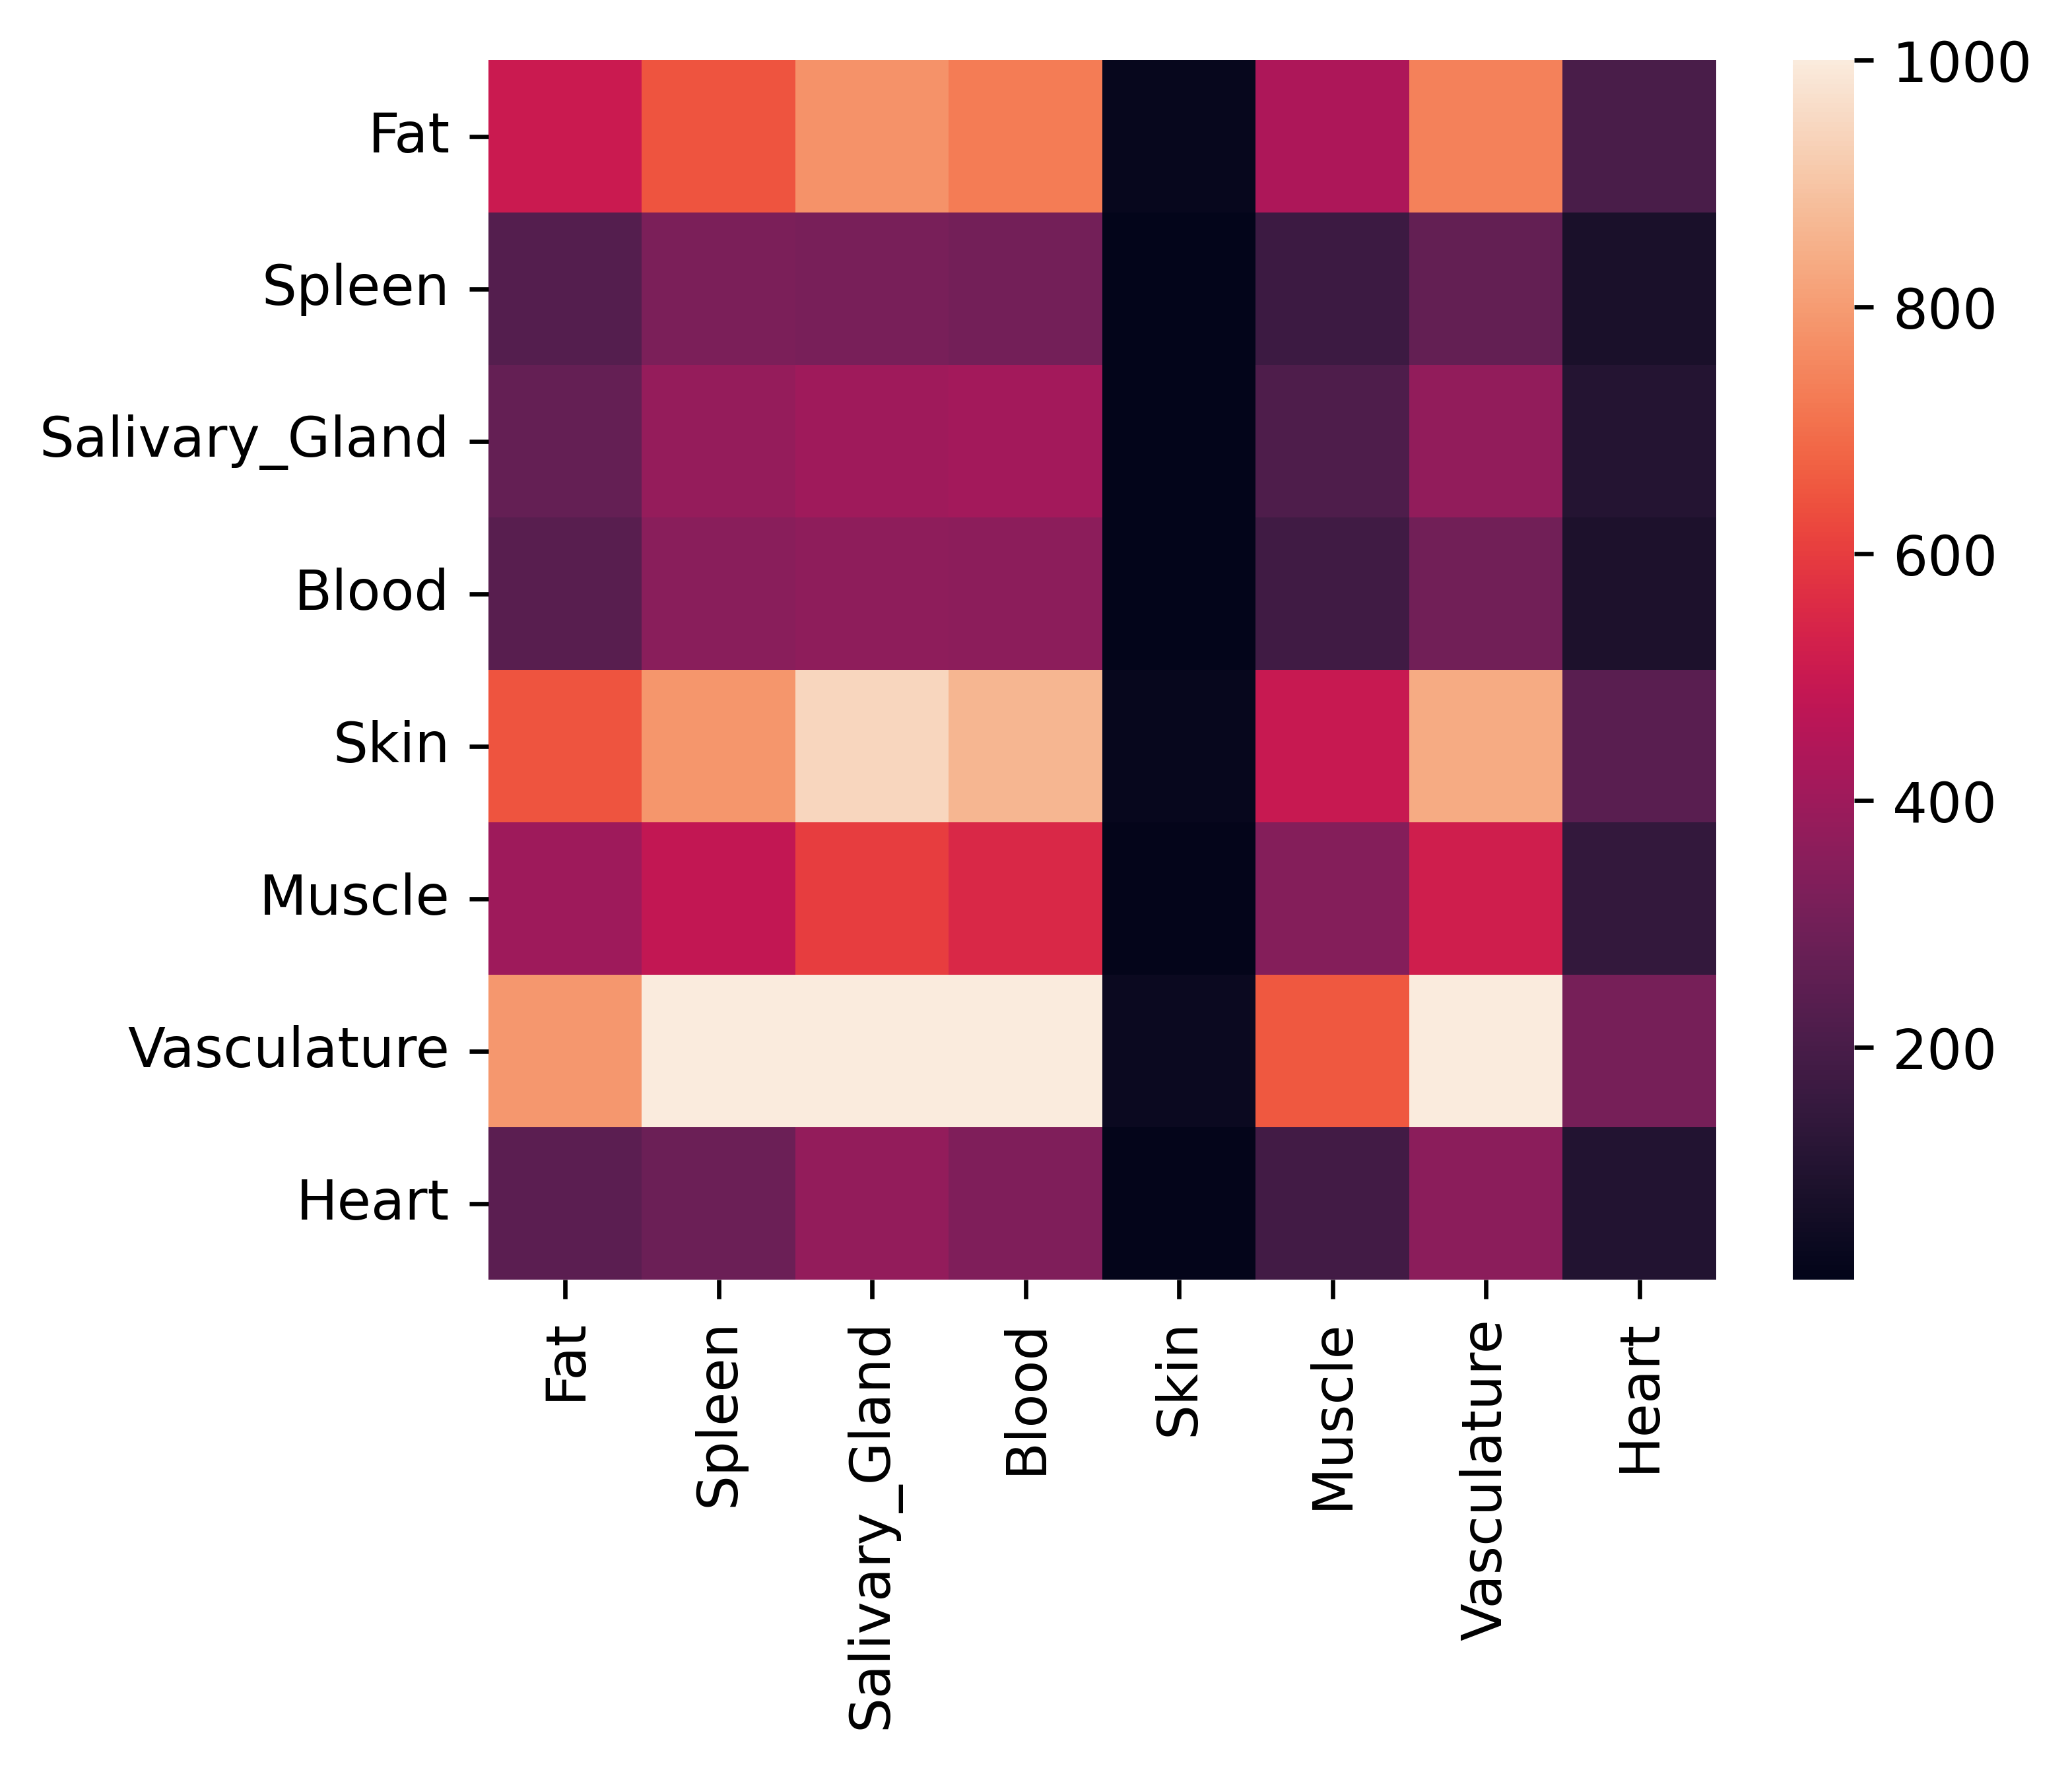

In [85]:
def plot_fig1b_3(mapping_dict,GTEx_data,TS_data):
    tissue_mtx = pd.DataFrame(np.zeros([len(mapping_dict.keys()),len(mapping_dict.keys())]))
    tissue_mtx.index = mapping_dict.keys()
    tissue_mtx.columns = mapping_dict.keys()
    for tissue_i in mapping_dict.keys():
        for tissue_j in mapping_dict.keys():
            tissue_mtx.loc[tissue_i, tissue_j] = len(set(GTEx_data[GTEx_data['tissue_rename'].isin(mapping_dict[tissue_i])].index)  & 
                                                     set(TS_data[TS_data['tissue']==tissue_j].index)
                                                                   )

    plt.subplots(1,1,dpi=600,figsize=(5,4))
    sns.heatmap(tissue_mtx,vmax=1000)
plot_fig1b_3(mapping_dict,GTEx_data_df,TS_data_df)

In [53]:
set([3])|set([3,4])

{3, 4}